# Table of Contents

In [2]:
%%javascript
Jupyter.notebook.execute_cells([0]);

<IPython.core.display.Javascript object>

# Introduction

This notebook contains a product synthesized from multiple notebooks over the course of this text analytics project. This analysis came about in partnership with the Fire Center at the University of Montana, and explores reports that combine Organizational Assesments with Relative Risk Decisions. The primary goal of the analysis was to find the text features that drive risk, but as is apparent from the vast amount of explorations contained, many smaller questions arose along the way. The data used is largely unexplored with text analytics and contains both features, categorical features, and a wealth of other variables about each fire report. 
   
The code contained in this notebook takes the data from its raw form and cleans it, tokenizes text with custom code, utilizes TFIDF vectorization to perform analysis, explores numerous approaches to statistical analysis, and concludes what, if any, valuable insights can be gained from the text.

# Imports

In the below cell I import a variety of python libraries and modules, preparing my notebook for text analysis, natural language processing, machine learning, and more.

In [1]:
import nltk
import csv
from datetime import timedelta
import os
from nltk.corpus import stopwords
import numpy as np
import sqlite3
from collections import Counter, defaultdict
from string import punctuation
import re
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
sw = stopwords.words('english')
import janitor
import spacy
from textblob import TextBlob
tb = TextBlob('')
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_lg')
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import importlib
import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import interact_manual, interactive_output
from IPython.display import display, clear_output
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import spacy
import math
from textblob import TextBlob
tb = TextBlob('')
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from random import randint
from sklearn.model_selection import RandomizedSearchCV
import winsound
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from spellchecker import SpellChecker
from textblob import TextBlob
import eli5
from eli5.sklearn import PermutationImportance
import warnings
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import words
nltk.download('punkt')
nltk.download('words')
from nltk.util import ngrams
import random
from wordcloud import WordCloud
import xgboost as xgb
import matplotlib.dates as mdates

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Here I import functions I have built for cleaning the data, and read in my raw data. The data was given to me by project managers in a csv format. All function files are available in the github repo.

In [2]:
#Import functions
from oarrCleaning import OARR_Clean_and_Check, cl_names

#Read in the data from a csv
OARR = pd.read_csv("OA_RRA_l2.csv", encoding='latin-1')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Basic Cleaning and Prep

In the below cells, I first utilize pyjanitor to clean the column names in the df. I then utilize a custom function that I created to perform the following tasks on the data:

- Fix an erroneous entry in the geo_area_name column
- Check the geo_area_name column for proper completion
- Ensure that each entry has a unique identifier
- Check the fire_name column and print any nan values
- Other column quality checks (see function file for a full breakdown)

In [3]:
#Use a function to clean column names
OARR = cl_names(OARR)

#Multi-step cleaning function for the data
OARR_Clean_and_Check(OARR)

The row(s) at index Index([3890, 4050, 8616, 16751, 16752, 16753, 16754, 16755, 16756, 16757], dtype='int64') have 'nan' string values in 'fire_name'.


# Process Text

In this section of the notebook I use functions I have built to process the text data in the fire reports. Below, I import said functions.

In [4]:
#Import text functions I have made
from text_functions import set_columns_to_string, process_text_column, categorize_columns, firestops, get_last_value

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###### Identifier Creation

Below I make a unique identifier for fire-risk combinations by combining fire id and fire relative risk decision. I chose to do this to more accurately distribute text across entries for analysis. Grouping all text into each id is great in theory, but not as much in practice as many fires change risk rating. Additionally, using individual reports falls apart as well with the amount of copy-pasting that goes on from one report to another. I also set the column order and ensure that any accidental index column crossover is dealt with. 

In [5]:
OARR = OARR.assign(wfdss_risk=(OARR['wfdss_id'].astype(str) + " - " + OARR['rrf_rr_desc']))

column_order = ['wfdss_risk'] + [col for col in OARR.columns if col != 'wfdss_risk']

OARR = OARR[column_order]

if 'unnamed_0' in OARR.columns:
    OARR = OARR.drop('unnamed_0', axis=1)

###### Create Useful Lists for Later

In the below cell, I make a list containing all note columns, risk decision columns, and fire identification columns. These will be useful later in the code.

In [6]:
notes = []
for column in OARR.columns:
    if 'notes' in column:
        notes.append(column) 
        
descs = []
for column in OARR.columns:
    if 'desc' in column:
        descs.append(column)
        
ids =[]
for column in OARR.columns:
    if '_id' in column:
        ids.append(column)
        
ctk = ids + notes + descs

x_notes = notes + ['combined_text']

text_risk_id = OARR[ctk]

###### Clean & Tokenize Text

Below I clean and tokenize the raw text and store it in a dataframe.

In [7]:
#Intialization of empty list to store unique tokens
combined_text = []

#Create a dictionary where the keys are columns in the previously created notes list
unique_sentence_dict = {col: {} for col in notes}

#Group the data by the identifier I created previously.
grouped_df = OARR.groupby('wfdss_risk')

for fire_id, group_df in grouped_df:
    for column_name in notes:
        #Call my function I imported above to process each text column.
        tokens = process_text_column(group_df, column_name)
        
        # Store the unique tokens for each column in a sub-dictionary
        unique_sentence_dict[column_name][fire_id] = tokens
        
        for token in tokens:
            if token not in combined_text:
                combined_text.append(token)

#Create a DataFrame to store text
temp = pd.DataFrame(unique_sentence_dict)
temp.reset_index(inplace=True)
temp.rename(columns={'index': 'wfdss_risk'}, inplace=True)

#Put the tokenized text into the DataFrame
for col in notes:
    temp[col] = temp[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

#Replace blank values with nan
temp.replace("", np.nan, inplace=True)

# #Create a column to hold all text for the fire. This will allow for easier analysis later.
# temp['combined_text'] = temp.apply(lambda row: ' '.join(str(x) for x in row.drop(['wfdss_risk']) if isinstance(x, str)), axis=1)

# if 'combined_text' in temp.columns:
#     temp = temp.drop('combined_text', axis =1)

#Fill missing values, remove extra whitespace, and casefold, clean, and tokenize text while removing 
#custom and normal stopwords
for col in notes:
    temp[col] = temp[col].fillna("")  
    temp[col] = temp[col].apply(lambda raw: " ".join(raw.split()) if isinstance(raw, str) else raw)
    temp[col] = temp[col].apply(lambda raw: " ".join([t.lower() for t in raw.split() if t.lower().isalpha() and t.lower() not in sw and t.lower() not in firestops]) if isinstance(raw, str) else "")

Now I utilize the data created above to finalize a DataFrame for analysis, simply called data.

In [8]:
#Create another grouped df
grouped_df2 = OARR.groupby('wfdss_risk')

#Utilize the get_last_value function to fill out the df
result_df = grouped_df2.apply(lambda group: group.apply(get_last_value))
#Reset Index
result_df.reset_index(drop=True, inplace=True)

#replace text columns to keep attribute columns
for column in notes:
    result_df[column] = temp[column]
    
#Create a df called 'data' for simple naming
data = result_df

#Iterate over each fire-risk to keep only non-redundant text
for id_ in data['wfdss_risk'].unique():
    mask = data['wfdss_risk'] == id_

    for col in notes:
        for i, row in data[mask].iterrows():
            if i > 0 and not pd.isnull(row[col]) and not pd.isnull(data.loc[i - 1, col]):
                previous_text = data.loc[i - 1, col]
                current_text = row[col]
                new_text = current_text.replace(previous_text, '').strip()
                data.at[i, col] = new_text

#Create a new column containing all text for each fire-risk
data['combined_text'] = data[notes].apply(lambda row: ' '.join(row), axis=1)

# Data Overview 

## The Reports

Here I provide a simple overview of when the data is from, and how many unique fire-risk combinations exist within it.

In [9]:
data['start_date_time'] = pd.to_datetime(data['start_date_time'])

# Date and Fire Summary Statistics
earliest_date_time = data['start_date_time'].min()
newest_date_time = data['start_date_time'].max()
date_diff = newest_date_time - earliest_date_time
total_rows = len(data)
total_fires = len(data['wfdss_id'].unique())

print("The earliest fire report in the data is:", earliest_date_time)
print("The most recent fire report in the data is:", newest_date_time)
print(f"In total, the data is comprised of {total_rows} entries over about {date_diff.days} days and {total_fires} unique fire-risk combinations. ")

The earliest fire report in the data is: 2011-04-28 17:10:00
The most recent fire report in the data is: 2022-11-23 13:27:00
In total, the data is comprised of 7665 entries over about 4226 days and 6195 unique fire-risk combinations. 


## Risk Changes

Below I plot the distributions of amounts of times a fires risk changes across the data.

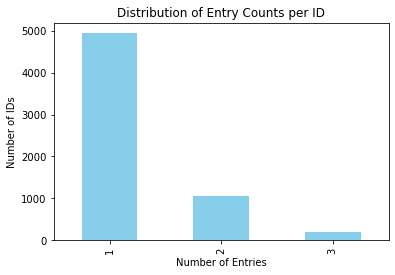

In [10]:
entry_counts = data['wfdss_id'].value_counts()

# Plot the distribution of entry counts
entry_counts.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Entry Counts per ID')
plt.xlabel('Number of Entries')
plt.ylabel('Number of IDs')
plt.show()

# Text Overview

In this section of the notebook I provide a broad look at the text in the data, utilizing the ntotes fields for each report. This includes common tokens and n-grams, as well as basic completion statistics. More importantly, I delve into the differences in text across risks and regions, as well as provide the opportunity for exploration by tokens of an individuals choosing.

In [11]:
from text_analysis_functions_wagers import count_ngrams, completion_percentage, basic_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Common Tokens

Below  is a simple wordcloud visualization of the common features in the text. This is not intended to be any form of hard-hitting analysis, but rather a visual introduction to the text.

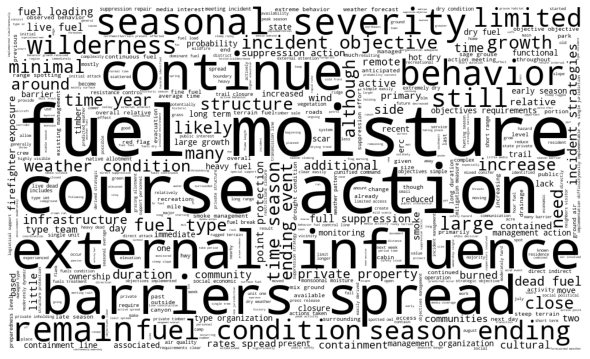

In [12]:
all_text = "".join(data['combined_text'])
text = all_text

colors = ["#000000"]

wordcloud = WordCloud(background_color="white", max_words=500, width=1000, height=600,
                      color_func=lambda *args, **kwargs: colors[0])

wordcloud.generate(all_text)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Common N-grams

Now I find the most common bigrams in the text. If you wish to find a different number of n-grams, simply modify the function arguments. These bigrams give an indication of what is frequently discussed in the text. In my opinion, they are all fairly expected.

In [13]:
result = count_ngrams(text, 2)
count = 0

for n_gram, frequency in result.items():
    if count < 15:
        print(f"{n_gram}: {frequency} times")
        count += 1
    else:
        break

('course', 'action'): 2360 times
('barriers', 'spread'): 2348 times
('external', 'influences'): 2233 times
('seasonal', 'severity'): 1994 times
('fuel', 'moistures'): 1636 times
('season', 'ending'): 1581 times
('incident', 'objectives'): 1391 times
('fuel', 'conditions'): 1355 times
('time', 'season'): 1350 times
('time', 'year'): 1149 times
('weather', 'conditions'): 1079 times
('private', 'property'): 1077 times
('incident', 'strategies'): 1070 times
('ending', 'event'): 1038 times
('fuel', 'moisture'): 1024 times


## Broad Data Information

Below, I calculate some descriptive statistics about the text data. I utilize functions I built for this project.

### Completion of  Notes Fields

As visible below, the majority of fields have a high completion rate. It is definitely worth noting that some fields are left blank over 10% of the time, even when multiple reports are brought into a fire-risk combination. 

In [14]:
completion_percentage(data,notes)

Below is the percantage of entires with at least some unique text for a fire-risk grouping:


{'hazf_notes': 91.29810828440965,
 'probf_notes': 88.81930854533594,
 'valf_notes': 91.1545988258317,
 'rrf_notes': 86.43183300717547,
 'spf_notes': 85.58382257012394,
 'impdif_f_notes': 87.71037181996087,
 'orgf_notes': 72.56360078277886}

### Summary Statistics of Notes Fields

In [15]:
results_df = basic_text(data,notes)
results_df = results_df.transpose()
results_df

,total_tokens,unique_tokens,average_tokens,avg_token_length,lexical_diversity,top_10
hazf_notes,193483,6148,25.242401,6.543438,0.031775,"[(fuel, 6516), (behavior, 5146), (fuels, 5086)..."
probf_notes,158328,6007,20.655969,6.502558,0.03794,"[(barriers, 5283), (season, 4599), (spread, 34..."
valf_notes,190057,9795,24.795434,6.934435,0.051537,"[(private, 3395), (cultural, 2331), (infrastru..."
rrf_notes,146982,6998,19.175734,6.868399,0.047611,"[(relative, 2340), (fuel, 1637), (fuels, 1632)..."
spf_notes,139675,6767,18.22244,7.315132,0.048448,"[(objectives, 3843), (private, 2847), (externa..."
impdif_f_notes,161584,6032,21.080757,7.199958,0.03733,"[(incident, 2533), (functional, 2336), (limite..."
orgf_notes,139169,6942,18.156425,7.213237,0.049882,"[(type, 2667), (objectives, 2375), (incident, ..."


In [16]:
at_results = basic_text(data,['combined_text'])
at_results =at_results.transpose()
at_results

,average_tokens,avg_token_length,lexical_diversity,top_10,total_tokens,unique_tokens
combined_text,147.329159,6.917737,0.015104,"[(fuel, 12415), (fuels, 10156), (private, 9326...",1129278,17057


In [17]:
at_results2 = at_results[results_df.columns]

In [18]:
temp_combined_df = pd.concat([results_df, at_results2], ignore_index=False)

In [19]:
temp_combined_df

,total_tokens,unique_tokens,average_tokens,avg_token_length,lexical_diversity,top_10
hazf_notes,193483,6148,25.242401,6.543438,0.031775,"[(fuel, 6516), (behavior, 5146), (fuels, 5086)..."
probf_notes,158328,6007,20.655969,6.502558,0.03794,"[(barriers, 5283), (season, 4599), (spread, 34..."
valf_notes,190057,9795,24.795434,6.934435,0.051537,"[(private, 3395), (cultural, 2331), (infrastru..."
rrf_notes,146982,6998,19.175734,6.868399,0.047611,"[(relative, 2340), (fuel, 1637), (fuels, 1632)..."
spf_notes,139675,6767,18.22244,7.315132,0.048448,"[(objectives, 3843), (private, 2847), (externa..."
impdif_f_notes,161584,6032,21.080757,7.199958,0.03733,"[(incident, 2533), (functional, 2336), (limite..."
orgf_notes,139169,6942,18.156425,7.213237,0.049882,"[(type, 2667), (objectives, 2375), (incident, ..."
combined_text,1129278,17057,147.329159,6.917737,0.015104,"[(fuel, 12415), (fuels, 10156), (private, 9326..."


In [20]:
temp_combined_df.to_csv("summarytext.csv")

## Differences By Risk - What Drives Risk?

Here I import functions to explore what drives each individual risk rating decision within the data. This will be explored much more in depth later in the analysis, but for understanding factors behind each risk this is a great reference.

In [21]:
from text_classification_functions import train_logistic_reg_for_one_risk, risk_other_machine
vectorizer =TfidfVectorizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### High

In [22]:
high_other_comb_texts, high_other_labels = risk_other_machine(data, 'high')
mod_other_comb_texts, mod_other_labels = risk_other_machine(data, 'mod')
low_other_comb_texts, low_other_labels = risk_other_machine(data,'low')

In [23]:
ho_model_high_risk, ho_lrx_train_high_risk, ho_lrx_test_high_risk, ho_lry_train_high_risk, ho_lry_test_high_risk \
    = train_logistic_reg_for_one_risk(high_other_comb_texts, high_other_labels, 'high','l2', 1, 1000)

ho_lry_pred_high_risk = ho_model_high_risk.predict(ho_lrx_test_high_risk)
ho_score_high_risk = accuracy_score(ho_lry_test_high_risk, ho_lry_pred_high_risk)

print(f"The model accuracy is {ho_score_high_risk}")
print("\nClassification Report:")
print(classification_report(ho_lry_test_high_risk, ho_lry_pred_high_risk))

The model accuracy is 0.7964774951076321

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       981
           1       0.77      0.62      0.69       552

    accuracy                           0.80      1533
   macro avg       0.79      0.76      0.77      1533
weighted avg       0.79      0.80      0.79      1533



In [24]:
report_dict = classification_report(ho_lry_test_high_risk, ho_lry_pred_high_risk, output_dict=True)

# Convert the classification report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to whatever you prefer
report_df.rename(columns={'index': 'metrics'}, inplace=True)

# Add a new row for the model accuracy at the end of the DataFrame
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame
final_report_df = pd.concat([report_df, accuracy_row])

# Print the DataFrame to ensure it looks correct
print(final_report_df)

               metrics  precision    recall  f1-score      support
0                    0   0.806599  0.897044  0.849421   981.000000
1                    1   0.771493  0.617754  0.686117   552.000000
2             accuracy   0.796477  0.796477  0.796477     0.796477
3            macro avg   0.789046  0.757399  0.767769  1533.000000
4         weighted avg   0.793958  0.796477  0.790619  1533.000000
accuracy           NaN        NaN       NaN  0.796477          NaN


In [25]:
val = 'high'
final_report_df['risk'] = val

In [26]:
final_report_df.to_csv("HighClassifReport.csv")

#### Insights

The penalized logistic regression model trained above predicts fire risk at a roughly 80% accuracy rate, which is significantly better than random guessing. Overall, I am satisfied with model performance. It is important to consider that the model is not perfect, and domain expertise may outweigh the models coefficient assignments.

The below features are the 20 that the model has identified as the strongest evidence for a given fire being classified as high risk. Tokens such as 'extreme', 'dry', and 'structures' appear as the three strongest tokens in terms of evidence for this class. These are not necessarily too interesting in my opinion, but are worth noting. 

From the tokens below it is worth noting that discussions of structures, homes, and other tokens associated with human population and infrastructure make up a good chunk of these influential tokens. This would suggest, with some assumption, that this topic is one that is heavily associated with the decision to designate a fire as high risk.

Additionally, the inclusion of 'team' and 'imt' (Incident Management Team) would suggest that the discussion of operational activities is possibly an indicator of a high relative risk designation.

In [27]:
txt = vectorizer.fit_transform(high_other_comb_texts)

feature_names = vectorizer.get_feature_names_out()

coefficients = ho_model_high_risk.coef_[0]

feature_coefficients = dict(zip(feature_names, coefficients))

sorted_features = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)

top_features = sorted_features[:20] 
for feature, coefficient in top_features:
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: extreme, Coefficient: 4.967278913815581
Feature: dry, Coefficient: 3.080155686925375
Feature: structures, Coefficient: 3.0428456532716357
Feature: large, Coefficient: 2.495758377662233
Feature: difficult, Coefficient: 2.472532110309322
Feature: team, Coefficient: 2.447416885834606
Feature: state, Coefficient: 2.3840279694045963
Feature: homes, Coefficient: 2.2353642013571284
Feature: continuous, Coefficient: 2.2214947352848764
Feature: record, Coefficient: 2.1821903050749074
Feature: imt, Coefficient: 2.0479331385162336
Feature: evacuations, Coefficient: 2.005251263710495
Feature: communities, Coefficient: 2.0021197332431218
Feature: throughout, Coefficient: 1.9792924761846107
Feature: long, Coefficient: 1.9647846303098824
Feature: crown, Coefficient: 1.9469276657341863
Feature: availability, Coefficient: 1.9451836488006538
Feature: community, Coefficient: 1.9125717677077896
Feature: spotting, Coefficient: 1.9051218781987753
Feature: private, Coefficient: 1.8914392084734881


In [28]:
feature_coefficients_df = pd.DataFrame(top_features, columns=['Feature', 'Coefficient'])
feature_coefficients_df['risk'] = 'high'

### Moderate

In [29]:
mod_logreg_model, modx_train, modx_test, mody_train, mody_test \
=train_logistic_reg_for_one_risk(mod_other_comb_texts, mod_other_labels, 'mod','l2', 1, 1000)
mody_pred = mod_logreg_model.predict(modx_test)
mod_logreg_acc = accuracy_score(mody_test, mody_pred)

print(f"The model accuracy is {mod_logreg_acc}")
print("\nClassification Report:")
print(classification_report(mody_test, mody_pred))

The model accuracy is 0.6151337247227658

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       952
           1       0.48      0.20      0.28       581

    accuracy                           0.62      1533
   macro avg       0.56      0.53      0.51      1533
weighted avg       0.58      0.62      0.56      1533



In [30]:
report_dict = classification_report(mody_test, mody_pred, output_dict=True)

# Convert the classification report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to whatever you prefer
report_df.rename(columns={'index': 'metrics'}, inplace=True)
# Add a new row for the model accuracy at the end of the DataFrame
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame
final_report_df2 = pd.concat([report_df, accuracy_row])

val = 'mod'
final_report_df2['risk'] = val


# Print the DataFrame to ensure it looks correct
print(final_report_df2)

               metrics  precision    recall  f1-score      support risk
0                    0   0.639660  0.870798  0.737544   952.000000  mod
1                    1   0.481013  0.196213  0.278729   581.000000  mod
2             accuracy   0.615134  0.615134  0.615134     0.615134  mod
3            macro avg   0.560337  0.533506  0.508137  1533.000000  mod
4         weighted avg   0.579534  0.615134  0.563655  1533.000000  mod
accuracy           NaN        NaN       NaN  0.796477          NaN  mod


#### Insights

A penalized logistic regression does not perform as well predicting moderate risk fires as it does the other risks. In fact, it predicts nearly 20% less accurately! At only about 62%, this result is not too impressive. In this case, be sure to consider the models accuracy when assessing the features that drive model decisions.

These top features are much less informative or immediately intuitive than those for high and low risk fires, but are still worth looking at. The presence of 'average', for example, does seem rather intuitive. Interestingly, the token 'hunting' appears in the top 20 tokens that present the strongest evidence. It may be worth exploring a connection between leisure activities and risk designation.

The tokens here seem more descriptive of fire control efforts than those for high risk, which were the actual units. Tokens like 'solely', 'mitigated', 'efforts', 'sufficient', 'adequate' and 'containment' could possibly support this statement.

In [31]:
txt = vectorizer.fit_transform(mod_other_comb_texts)

feature_names = vectorizer.get_feature_names_out()

coefficients = mod_logreg_model.coef_[0]

feature_coefficients = dict(zip(feature_names, coefficients))

sorted_features = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)

top_features = sorted_features[:20] 
for feature, coefficient in top_features:
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: still, Coefficient: 2.0477254451736275
Feature: average, Coefficient: 1.6434273518630784
Feature: scars, Coefficient: 1.6221020963720856
Feature: consists, Coefficient: 1.5329817089138131
Feature: away, Coefficient: 1.4572253486806332
Feature: mitigated, Coefficient: 1.4318488237626685
Feature: solely, Coefficient: 1.373769420301688
Feature: efforts, Coefficient: 1.3430590790599508
Feature: vegetation, Coefficient: 1.332073471364472
Feature: hunting, Coefficient: 1.2954144467171547
Feature: slightly, Coefficient: 1.2675309330346178
Feature: sufficient, Coefficient: 1.2356228936457827
Feature: short, Coefficient: 1.2275438418215538
Feature: containment, Coefficient: 1.2083918796574313
Feature: organization, Coefficient: 1.191447300660525
Feature: term, Coefficient: 1.1267809023489432
Feature: surface, Coefficient: 1.1153390091515014
Feature: joker, Coefficient: 1.1127915679735803
Feature: although, Coefficient: 1.1069534243764918
Feature: adequate, Coefficient: 1.10022687280631

In [32]:
feature_coefficients_df2 = pd.DataFrame(top_features, columns=['Feature', 'Coefficient'])
feature_coefficients_df2['risk'] = 'mod'

### Low

In [33]:
low_logreg_model, lowx_train, lowx_test, lowy_train, lowy_test = train_logistic_reg_for_one_risk(low_other_comb_texts, low_other_labels, 'low', 'l2', 1, 1000)
lowy_pred = low_logreg_model.predict(lowx_test)
low_logreg_acc = accuracy_score(lowy_test, lowy_pred)

print(f"The model accuracy is {low_logreg_acc}")
print("\nClassification Report:")
print(classification_report(lowy_test, lowy_pred))


The model accuracy is 0.79191128506197

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1133
           1       0.75      0.30      0.43       400

    accuracy                           0.79      1533
   macro avg       0.77      0.63      0.65      1533
weighted avg       0.78      0.79      0.76      1533



In [34]:
report_dict = classification_report(lowy_test, lowy_pred, output_dict=True)

# Convert the classification report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to whatever you prefer
report_df.rename(columns={'index': 'metrics'}, inplace=True)

# Add a new row for the model accuracy at the end of the DataFrame
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame
final_report_df3 = pd.concat([report_df, accuracy_row])

val = 'low'
final_report_df3['risk'] = val


# Print the DataFrame to ensure it looks correct
print(final_report_df3)

               metrics  precision    recall  f1-score      support risk
0                    0   0.797080  0.963813  0.872553  1133.000000  low
1                    1   0.748466  0.305000  0.433393   400.000000  low
2             accuracy   0.791911  0.791911  0.791911     0.791911  low
3            macro avg   0.772773  0.634406  0.652973  1533.000000  low
4         weighted avg   0.784396  0.791911  0.757964  1533.000000  low
accuracy           NaN        NaN       NaN  0.796477          NaN  low


#### Insights

Low risk fires are classified at nearly the same exact accuracy as high risk fires. A penalized logistic regression model classifies text to low risk fires at nearly 80% accuracy. This is definitely a satisfactory perofrmance, given the text being worked with.

The model's delineation of features for low-risk fires reveals a starkly different landscape from those associated with moderate or high-risk classifications. Many of the tokens indicative of a low risk fire are intuitive, or may feel obvious, but there are interesting themes that can be observed.

Meteorological conditions, indicated by 'precipitation', 'rain', 'monsoonal', 'snow', and 'moisture', emerge as significant factors in reducing fire risk. These terms collectively point to the critical role of precipitation patterns in mitigating fire potential, with moisture acting as a natural suppressant that diminishes the likelihood and severity of fires.

The use of tokens like 'minimal' (the strongest evidence for a low risk fire), 'little', and easily, suggest that words that could come off as downplaying a situation are seemingly almost always used when the situation is under control. The tokens 'sparse' and 'little' indicate that discussion of scarcity could also be predictive of a low risk fire.



In [35]:
txt = vectorizer.fit_transform(low_other_comb_texts)

feature_names = vectorizer.get_feature_names_out()

coefficients = low_logreg_model.coef_[0]

feature_coefficients = dict(zip(feature_names, coefficients))

sorted_features = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)

top_features = sorted_features[:20] 
for feature, coefficient in top_features:
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: minimal, Coefficient: 3.751127560896262
Feature: monitor, Coefficient: 2.78498244251598
Feature: precipitation, Coefficient: 2.6850898151898215
Feature: sparse, Coefficient: 2.390884138982884
Feature: little, Coefficient: 2.3076974354828557
Feature: surrounded, Coefficient: 2.2915912629886646
Feature: monitoring, Coefficient: 2.1893136293717492
Feature: late, Coefficient: 2.1422054382101163
Feature: fall, Coefficient: 2.0684302820456004
Feature: rain, Coefficient: 2.04527895417375
Feature: received, Coefficient: 2.0352428790090915
Feature: repair, Coefficient: 2.0179913706566173
Feature: contained, Coefficient: 1.9896983461735585
Feature: smoldering, Coefficient: 1.970676454890964
Feature: monsoonal, Coefficient: 1.9555764410773793
Feature: monitored, Coefficient: 1.9312947793688513
Feature: snow, Coefficient: 1.9111606152150724
Feature: elevation, Coefficient: 1.8597346359542761
Feature: moisture, Coefficient: 1.8501849811824986
Feature: easily, Coefficient: 1.727304269117709

In [36]:
feature_coefficients_df3 = pd.DataFrame(top_features, columns=['Feature', 'Coefficient'])
feature_coefficients_df3['risk'] = 'low'

In [37]:
feature_coefficients_df_final = pd.concat([feature_coefficients_df, feature_coefficients_df2, feature_coefficients_df3], ignore_index=True)

In [38]:
feature_coefficients_df_final.to_csv("features3risksingleclass.csv")

### General Text Differences

In [39]:
combined_df = pd.concat([final_report_df, final_report_df2, final_report_df3], ignore_index=True)
combined_df

,metrics,precision,recall,f1-score,support,risk
0,0,0.806599,0.897044,0.849421,981.000000,high
1,1,0.771493,0.617754,0.686117,552.000000,high
2,accuracy,0.796477,0.796477,0.796477,0.796477,high
3,macro avg,0.789046,0.757399,0.767769,1533.000000,high
4,weighted avg,0.793958,0.796477,0.790619,1533.000000,high
5,NaN,NaN,NaN,0.796477,NaN,high
6,0,0.639660,0.870798,0.737544,952.000000,mod
7,1,0.481013,0.196213,0.278729,581.000000,mod
8,accuracy,0.615134,0.615134,0.615134,0.615134,mod
9,macro avg,0.560337,0.533506,0.508137,1533.000000,mod


In [40]:
combined_df.to_csv("singleriskclass.csv")

## Regional Differences

### Risk

C:\Users\aidan\AppData\Local\Temp\ipykernel_960\978979965.py:14: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.histplot(


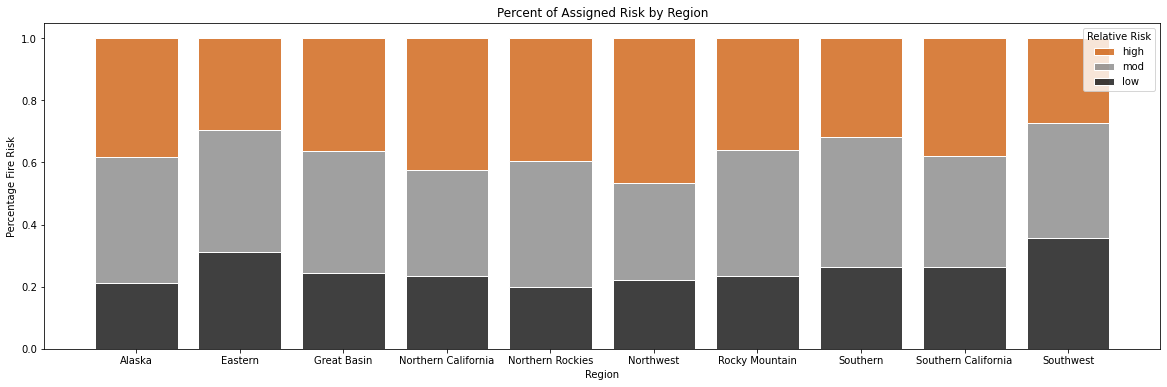

In [41]:
df_grouped = data.groupby(['geo_area_name', 'rrf_rr_desc']).size().reset_index(name='count')

region_total = df_grouped.groupby('geo_area_name')['count'].sum()
df_merged = pd.merge(df_grouped, region_total, left_on='geo_area_name', right_index=True, suffixes=('', '_total'))
df_merged['percent'] = df_merged['count'] / df_merged['count_total']
df_result = df_merged[['count', 'geo_area_name', 'rrf_rr_desc', 'percent']].sort_values(['geo_area_name', 'count'], ascending=[True, False])

custom_order = ['high', 'mod', 'low']

# Reorder the 'rrf_rr_desc' column based on the custom order
df_result['rrf_rr_desc'] = pd.Categorical(df_result['rrf_rr_desc'], categories=custom_order, ordered=True)

# Plot the stacked histogram
ax = sns.histplot(
    df_result,
    x='geo_area_name',
    weights='percent',
    hue='rrf_rr_desc',
    multiple='stack',
    palette=['#cc5500', '#808080','#000000','#000000'],
    edgecolor='white',
    shrink=0.8
)

ax.set_title('Percent of Assigned Risk by Region')
ax.set(xlabel='Region', ylabel='Percentage Fire Risk')
legend = ax.get_legend()
legend.set_title('Relative Risk')

fig = ax.get_figure()
fig.set_size_inches(20, 6)

plt.show()

In [42]:
df_result['total_fire'] = df_result.groupby('geo_area_name')['count'].transform('sum')
df3 = df_result[df_result['rrf_rr_desc'] == ("high")]
x = df3['total_fire'].corr(df3['percent'])
print("The percentage of fires designated as high risk has a correlation coefficient of " + str(round(x,6)) + " with the number of total fires")

The percentage of fires designated as high risk has a correlation coefficient of 0.290057 with the number of total fires


### Text

##### Disproportionate Tokens

In [43]:
valid_word_set = set(words.words())

regions = data['geo_area_name'].unique()
region_texts = {region: " ".join(data[data['geo_area_name'] == region]['combined_text']) for region in regions}

region_token_freqs = {region: FreqDist(word_tokenize(text.lower())) for region, text in region_texts.items()}

tokens_relative_freq = {}

for region, freq_dist in region_token_freqs.items():
    other_regions_freq = {other_region: FreqDist(word_tokenize(text.lower())) for other_region, text in region_texts.items() if other_region != region}
    
    tokens_relative_freq[region] = {}
    for token, freq in freq_dist.items():
        other_regions_total_freq = sum([other_freq[token] for other_freq in other_regions_freq.values() if token in other_freq])
        relative_freq = freq / (other_regions_total_freq + freq) 
        
        tokens_relative_freq[region][token] = relative_freq

for region, token_freqs in tokens_relative_freq.items():
    text = region_texts[region]  
    tokens = word_tokenize(text.lower())  
    
    region_freq_dist = FreqDist(tokens) 
    
    top_words = [{'word': word, 'freq': freq, 'count': region_freq_dist[word]} for word, freq in token_freqs.items() if word.isalpha() and word.lower() in valid_word_set and region_freq_dist[word] > 10 and freq < 1.0]
    top_words = sorted(top_words, key=lambda x: x['freq'], reverse=True)[:10]
    
    print(f"Region {region}: Top Valid Words (Appearing >10 times) with Frequencies and Counts:")
    for word_info in top_words:
        word = word_info['word']
        word_freq = word_info['freq']
        word_count = word_info['count']
        print(f"'{word}' (Frequency: {word_freq}, Count: {word_count})")
    print()

Region Southern: Top Valid Words (Appearing >10 times) with Frequencies and Counts:
'arson' (Frequency: 0.9047619047619048, Count: 19)
'stumpy' (Frequency: 0.9, Count: 18)
'canal' (Frequency: 0.875, Count: 14)
'parkway' (Frequency: 0.8666666666666667, Count: 13)
'swamp' (Frequency: 0.8305084745762712, Count: 49)
'cypress' (Frequency: 0.8301886792452831, Count: 44)
'irene' (Frequency: 0.8125, Count: 13)
'clay' (Frequency: 0.7857142857142857, Count: 11)
'organic' (Frequency: 0.7065217391304348, Count: 65)
'outer' (Frequency: 0.6875, Count: 11)

Region Southwest: Top Valid Words (Appearing >10 times) with Frequencies and Counts:
'apache' (Frequency: 0.9821428571428571, Count: 110)
'fe' (Frequency: 0.9629629629629629, Count: 26)
'sunflower' (Frequency: 0.9615384615384616, Count: 25)
'outlet' (Frequency: 0.9473684210526315, Count: 18)
'cuckoo' (Frequency: 0.9333333333333333, Count: 14)
'calf' (Frequency: 0.9285714285714286, Count: 13)
'mesquite' (Frequency: 0.9285714285714286, Count: 13)
'c

In [44]:
# Assuming 'data' is your DataFrame containing the text and region information

valid_word_set = set(words.words())

regions = data['geo_area_name'].unique()
region_texts = {region: " ".join(data[data['geo_area_name'] == region]['combined_text']) for region in regions}

region_token_freqs = {region: FreqDist(word_tokenize(text.lower())) for region, text in region_texts.items()}

tokens_relative_freq = {}

# Initialize list for DataFrame rows
df_rows = []

for region, freq_dist in region_token_freqs.items():
    other_regions_freq = {other_region: FreqDist(word_tokenize(text.lower())) for other_region, text in region_texts.items() if other_region != region}
    
    tokens_relative_freq[region] = {}
    for token, freq in freq_dist.items():
        other_regions_total_freq = sum([other_freq[token] for other_freq in other_regions_freq.values() if token in other_freq])
        relative_freq = freq / (other_regions_total_freq + freq)
        
        tokens_relative_freq[region][token] = relative_freq

for region, token_freqs in tokens_relative_freq.items():
    text = region_texts[region]  
    tokens = word_tokenize(text.lower())  
    
    region_freq_dist = FreqDist(tokens) 
    
    top_words = [{'region': region, 'word': word, 'relative_freq': freq, 'count': region_freq_dist[word]} for word, freq in token_freqs.items() if word.isalpha() and word.lower() in valid_word_set and region_freq_dist[word] > 10 and freq < 1.0]
    top_words = sorted(top_words, key=lambda x: x['relative_freq'], reverse=True)[:10]
    
    # Append each word's info as a dictionary to df_rows
    df_rows.extend(top_words)

# Create DataFrame
df = pd.DataFrame(df_rows)

# Optionally, print the DataFrame to see its content
df.to_csv("region_disproportion_words.csv")


## Tokens of Interest

In [45]:
from text_analysis_functions_wagers import contains_target_word, percentage_with_target_words, \
percentage_by_risk, extract_context, extract_ordered_ngrams

###### Set target words below!

In [46]:
target_words = ["suppression", "containment", "structure", "communities", "barriers", "smoke"]

In [47]:
toi = data[x_notes + descs]

### How often do they appear?

In [48]:
percentage_with_target_words(toi,target_words)

The word 'barriers' appears in 51.64% of the combined notes fields for fires.
The word 'structure' appears in 40.03% of the combined notes fields for fires.
The word 'smoke' appears in 32.41% of the combined notes fields for fires.
The word 'suppression' appears in 32.13% of the combined notes fields for fires.
The word 'containment' appears in 16.37% of the combined notes fields for fires.
The word 'communities' appears in 13.07% of the combined notes fields for fires.


In [49]:
percentage_by_risk(toi, target_words)

Risk: High
The word 'barriers' appears in 58.63% of the texts for this risk.
The word 'structure' appears in 52.03% of the texts for this risk.
The word 'suppression' appears in 38.99% of the texts for this risk.
The word 'smoke' appears in 32.22% of the texts for this risk.
The word 'communities' appears in 19.36% of the texts for this risk.
The word 'containment' appears in 16.46% of the texts for this risk.

Risk: Mod
The word 'barriers' appears in 48.79% of the texts for this risk.
The word 'structure' appears in 35.42% of the texts for this risk.
The word 'smoke' appears in 32.31% of the texts for this risk.
The word 'suppression' appears in 31.20% of the texts for this risk.
The word 'containment' appears in 16.52% of the texts for this risk.
The word 'communities' appears in 10.21% of the texts for this risk.

Risk: Low
The word 'barriers' appears in 45.48% of the texts for this risk.
The word 'smoke' appears in 32.85% of the texts for this risk.
The word 'structure' appears in 

### What is the context surrounding them?

In [50]:
con_dict = {}  
context_words_dict_alpha = {}  
context_window_size = 5

for word in target_words:
    con_dict[word] = {}
    context_words_dict_alpha[word] = {}  # Initialize context_words_dict_alpha[word] as an empty dictionary
    
    for index, row in toi.iterrows():
        text = row['combined_text']

        if 'default_risk' not in con_dict[word]:
            con_dict[word]['default_risk'] = []

        contexts = extract_context(text, word, context_window_size)
        con_dict[word]['default_risk'].extend(contexts)
        
    for risk_description, c in con_dict[word].items():
        all_words = [w.lower() for context in c for w in context if not w.lower() == word]
        common_words = Counter(all_words).most_common(5)  # Change 5 to the desired number of common words
        context_words_dict_alpha[word]['default_risk'] = common_words

In [51]:
def plot_function(word):
    plt.figure(figsize=(8, 6))
    
    # Ensure there is data for the given token in the dictionary
    if 'default_risk' in context_words_dict_alpha.get(word, {}):  # Updated from cwd
        common_words, counts = zip(*context_words_dict_alpha[word]['default_risk'])  # Updated from cwd
        plt.bar(common_words, counts)
        plt.title(f"Common Tokens appearing in Context for '{word}'")  # Updated title
        plt.xlabel("Words")
        plt.ylabel("Count")
        plt.show()
    else:
        print(f"No data available for combined text for {word}")

# Create buttons for user interaction
word_buttons = [widgets.Button(description=word) for word in target_words]

def button_click_handler(button):
    with output_area:
        clear_output(wait=True)
        plot_function(button.description)

for button in word_buttons:
    button.on_click(button_click_handler)

# Populate interactive buttons
button_box = widgets.HBox(word_buttons)
display(button_box)

# Make a separate area for the plots to show up
output_area = widgets.Output()

# Display the plots
display(output_area)

with output_area:
    random_button = random.choice(word_buttons)
    plot_function(random_button.description)

Output()

###### By Risk

In [52]:
con_risk_dict = {}  # Updated from conDict
context_words_dict = {}  # Updated from cwd
context_window_size = 5

for word in target_words:
    con_risk_dict[word] = {}
    context_words_dict[word] = {}  # Initialize context_words_dict[word] as an empty dictionary
    
    for index, row in toi.iterrows():
        risk_description = row['rrf_rr_desc']
        text = row['combined_text']

        if risk_description not in con_risk_dict[word]:
            con_risk_dict[word][risk_description] = []

        contexts = extract_context(text, word, context_window_size)
        con_risk_dict[word][risk_description].extend(contexts)
        
    for risk_description, c in con_risk_dict[word].items():
        all_words = [w.lower() for context in c for w in context if not w.lower() == word]
        common_words = Counter(all_words).most_common(5)  # Change 5 to the desired number of common words
        context_words_dict[word][risk_description] = common_words
        
for word, risk_descriptions in context_words_dict.items():
    print(f"Word: {word}")
    for risk_description, common_words in risk_descriptions.items():
        print(f"  Risk Description: {risk_description}")
        print("    Common Words:")
        for word, count in common_words:
            print(f"      {word}: {count}")

Word: suppression
  Risk Description: mod
    Common Words:
      full: 333
      actions: 300
      incident: 234
      efforts: 233
      objectives: 217
  Risk Description: high
    Common Words:
      full: 871
      objectives: 536
      incident: 433
      actions: 382
      strategy: 326
  Risk Description: low
    Common Words:
      repair: 298
      actions: 195
      efforts: 134
      incident: 103
      objectives: 98
Word: containment
  Risk Description: mod
    Common Words:
      lines: 250
      suppression: 147
      spread: 122
      barriers: 114
      reduced: 108
  Risk Description: high
    Common Words:
      lines: 195
      growth: 114
      barriers: 101
      spread: 88
      conditions: 86
  Risk Description: low
    Common Words:
      lines: 252
      suppression: 94
      behavior: 91
      spread: 91
      growth: 82
Word: structure
  Risk Description: mod
    Common Words:
      protection: 135
      historic: 40
      one: 37
      conditions: 37
    

In [53]:
def plot_risks(word):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Ensure there is data for the given token in the dictionary
    if word in context_words_dict:
        # Sort risk descriptions based on counts
        sorted_risks = sorted(context_words_dict[word].items(), key=lambda x: sum(count for word, count in x[1]), reverse=True)

        for ax, (risk_description, common_words) in zip(axes, sorted_risks):
            words, counts = zip(*common_words)
            ax.bar(words, counts)
            ax.set_title(risk_description)
            ax.set_xlabel("Words")
            ax.set_ylabel("Count")

        plt.show()
    else:
        print(f"No data available for combined text for {word}")

# Create buttons for user interaction
word_buttons = [widgets.Button(description=word, layout=Layout(width='100px')) for word in target_words]

# Function to handle button click
def button_click_handler(button):
    with output_area:
        clear_output(wait=True)
        plot_risks(button.description)

# Assign a random button to be clicked automatically
random_button = random.choice(word_buttons)
button_click_handler(random_button)

# Attach click handler to buttons
for button in word_buttons:
    button.on_click(button_click_handler)

# Populate interactive buttons
button_box = widgets.HBox(word_buttons)
display(button_box)

# Make a separate area for the plots to show up
output_area = widgets.Output()

# Display the plots
display(output_area)

# Use plot function to display plot
with output_area:
    plot_risks(random_button.description)

Output()

### Let's take a look at common ngrams

In [54]:
common_ordered_ngrams_by_risk = {}

for word in target_words:
    common_ordered_ngrams_by_risk[word] = {}
    for risk_description, contexts in con_risk_dict[word].items(): 

        ordered_ngrams = extract_ordered_ngrams(contexts, 3)

        ordered_ngram_counts = Counter(ordered_ngrams)

        most_common_ordered_ngrams = ordered_ngram_counts.most_common(10)

        common_ordered_ngrams_by_risk[word][risk_description] = most_common_ordered_ngrams

for word, risk_descriptions in common_ordered_ngrams_by_risk.items():
    print(f"Word: {word}")
    for risk_description, ngram_counts in risk_descriptions.items():
        print(f"  Risk Description: {risk_description}")
        print("    Most Common Ordered Ngrams:")
        for ngram, count in ngram_counts:
            print(f"      {ngram}: {count}")
        print()  # Add an empty line between risk descriptions
    print()  # Add an empty line between words

Word: suppression
  Risk Description: mod
    Most Common Ordered Ngrams:
      full suppression strategy: 50
      suppression actions taken: 29
      conditions shortages suppression: 25
      likelihood success least: 25
      unusual conditions shortages: 24
      shortage suppression response: 23
      shortages suppression shortage: 22
      suppression shortage suppression: 22
      appropriate suppression protect: 22
      suppression protect cultural: 20

  Risk Description: high
    Most Common Ordered Ngrams:
      full suppression smallest: 143
      full suppression strategy: 128
      suppression smallest possible: 114
      objectives full suppression: 105
      full suppression objectives: 87
      conflict full suppression: 84
      suppression objectives full: 72
      involved coordinated suppression: 60
      strategies full suppression: 59
      conducive highly involved: 56

  Risk Description: low
    Most Common Ordered Ngrams:
      suppression repair work: 21


# Topic Modeling

# Sentiment Analyses 

In [55]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [56]:
sent_data = data.copy()
cols_to_analyze = notes.copy()
cols_to_analyze.append('combined_text')
cols_to_analyze

['hazf_notes',
 'probf_notes',
 'valf_notes',
 'rrf_notes',
 'spf_notes',
 'impdif_f_notes',
 'orgf_notes',
 'combined_text']

In [57]:
for col in cols_to_analyze:
    sent_data[[f'{col}_polarity', f'{col}_subjectivity']] = sent_data[col].apply(lambda x: pd.Series(analyze_sentiment(x)))

### Subjectivity

In [58]:
subjectivity_cols = [col for col in sent_data.columns if 'subjectivity' in col]
average_subjectivity = {col: sent_data[col].mean() for col in subjectivity_cols}

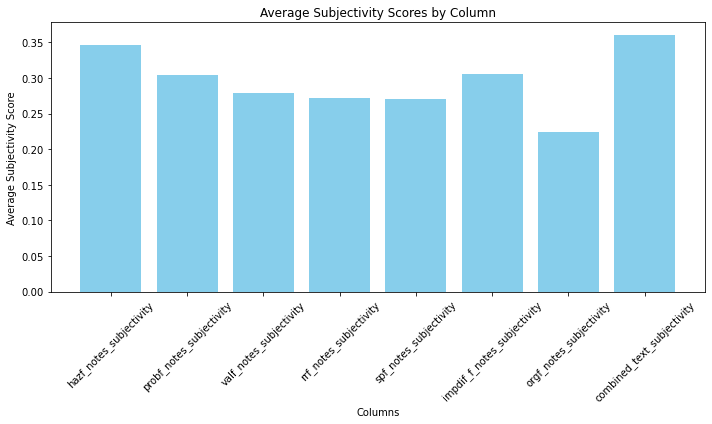

In [59]:
categories = average_subjectivity.keys()
scores = average_subjectivity.values()

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, scores, color='skyblue')
plt.title('Average Subjectivity Scores by Column')
plt.xlabel('Columns')
plt.ylabel('Average Subjectivity Score')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout() 
plt.show()

In [60]:
max_min_subj = {}

for col in subjectivity_cols:
    max_val = sent_data[col].max()
    min_val = sent_data[col].min()
    
    max_min_subj[col] = {'max':max_val, 'min':min_val}

In [61]:
max_min_subj_df = pd.DataFrame(max_min_subj).T
max_min_subj_df

,max,min
hazf_notes_subjectivity,1.0,0.0
probf_notes_subjectivity,1.0,0.0
valf_notes_subjectivity,1.0,0.0
rrf_notes_subjectivity,1.0,0.0
spf_notes_subjectivity,1.0,0.0
impdif_f_notes_subjectivity,1.0,0.0
orgf_notes_subjectivity,1.0,0.0
combined_text_subjectivity,1.0,0.0


###### Examine 1.0 Values

In [62]:
for col in subjectivity_cols:
    # Identify the original text column name by removing '_Subjectivity'
    text_col = col.replace('_subjectivity', '')
    
    # Filter the DataFrame for rows where the subjectivity score is 1.0
    max_subjectivity_texts = sent_data[sent_data[col] == 1.0][text_col]
    
    print(f"Texts with max subjectivity in {text_col}:")
    for text in max_subjectivity_texts.head(10):
        print(text)
    break

Texts with max subjectivity in hazf_notes:
bug kill behavior drying cold front passage size behavior drying trend could moved size
extreme behavior rates difficult control even using anticipating haines ercs
grass brush toward prefedio footprint china grass brush toward prefedio footprint china grass brush toward prefedio china precipitation received slowing forward rate precipitation occurred slowing forward rate appreciable amount precipitation occurred slowing forward rate heel flanks cold rain grass
extreme behavior rapid growth power lines
tundra fuels likely rained soon called
behavior fuel types moisture levels extreme behavior forecast indicating relief worsening
burnning since fuel moisture inhibit intense growth lack access continuity fuels
fuels extremely behavior shown rapid
become established continous fuels likely continue grow weather change
fuel loading extreme drought excessively humidities weather patterns created explosive conditions resulting rapid advance


### Initial Takeaways - Subjectivity

### Polarity

In [63]:
polarity_cols = [col for col in sent_data.columns if 'polarity' in col]
average_polarity = {col: sent_data[col].mean() for col in polarity_cols}

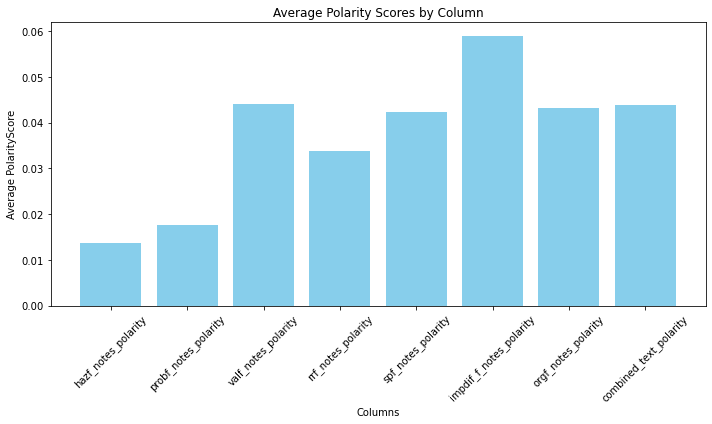

In [64]:
categories = average_polarity.keys()
scores = average_polarity.values()

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, scores, color='skyblue')
plt.title('Average Polarity Scores by Column')
plt.xlabel('Columns')
plt.ylabel('Average PolarityScore')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout() 
plt.show()

In [67]:
max_min_pola = {}

for col in polarity_cols:
    max_val = sent_data[col].max()
    min_val = sent_data[col].min()
    
    max_min_pola[col] = {'max':max_val, 'min':min_val}

In [68]:
max_min_pola_df = pd.DataFrame(max_min_pola).T
max_min_pola_df

,max,min
hazf_notes_polarity,1.0,-0.9
probf_notes_polarity,1.0,-0.6
valf_notes_polarity,1.0,-0.8
rrf_notes_polarity,1.0,-0.8
spf_notes_polarity,1.0,-0.5
impdif_f_notes_polarity,1.0,-1.0
orgf_notes_polarity,1.0,-0.5
combined_text_polarity,1.0,-0.5


In [69]:
for col in polarity_cols:
    # Identify the original text column name by removing '_Subjectivity'
    text_col = col.replace('_polarity', '')
    
    # Filter the DataFrame for rows where the subjectivity score is 1.0
    max_polarity_texts = sent_data[sent_data[col] == 1.0][text_col]
    
    print(f"Texts with max polarity in {text_col}:")
    for text in max_polarity_texts.head(10):
        print(text)


Texts with max polarity in hazf_notes:
occurs murphy ridge timber spotting grass behavior best described passive crown size estimated size estimated
Texts with max polarity in probf_notes:
handcrews making excellent progress remaining probibility growth reduced probibility smokes visible
barriers greatest spread season severity season region surrounding
Texts with max polarity in valf_notes:
mount magazine state park lodge scenic viewing state hwy state park property mile wind district excellent community support wildland suppression
emigrant infrastructure wilderness greatest management
Texts with max polarity in rrf_notes:
greatest linked behavior firefighter safety mortality levels trees result mountain pine beetle mitigation hazard priority personnel involved mitigation hazard priority personnel involved incident addressed throughout incident controlled remaining associated hazard trees result mountain pine beetle poses firefighters perform remaining checks calling
risks greatest f

In [70]:
for col in polarity_cols:
    # Identify the original text column name by removing '_Subjectivity'
    text_col = col.replace('_polarity', '')
    
    # Filter the DataFrame for rows where the subjectivity score is 1.0
    max_polarity_texts = sent_data[sent_data[col] == -1.0][text_col]
    
    print(f"Texts with min polarity in {text_col}:")
    for text in max_polarity_texts.head(10):
        print(text)


Texts with min polarity in hazf_notes:
Texts with min polarity in probf_notes:
Texts with min polarity in valf_notes:
Texts with min polarity in rrf_notes:
Texts with min polarity in spf_notes:
Texts with min polarity in impdif_f_notes:
devastating history make implementing course
Texts with min polarity in orgf_notes:
Texts with min polarity in combined_text:


### Initial Takeaways - Polarity

## Sentiment in Relationship to Risk Decision

### Subjectivity

In [ ]:
avg_subj_by_category = sent_data.groupby('rrf_rr_desc')[subjectivity_cols].mean().reset_index()

categories = avg_subj_by_category['rrf_rr_desc'].unique()

n_text_fields = len(avg_subj_by_category.columns) - 1

In [ ]:
# Melting the DataFrame to have a long format to facilitate the use od Seaborn for clustered bar chart
melted_data = sent_data.melt(id_vars=['rrf_rr_desc'], value_vars=subjectivity_cols, var_name='Text_Field', value_name='Average_Subjectivity')

# Remove the _subjectivity to reduce clutter
melted_data['Text_Field'] = melted_data['Text_Field'].str.replace('_subjectivity', '').str.replace('_', ' ')


plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Creating the bar plot
ax = sns.barplot(x='Text_Field', y='Average_Subjectivity', hue='rrf_rr_desc', data=melted_data, palette="coolwarm")

# Adding labels and title
plt.xlabel('Text Fields', fontsize=14)
plt.ylabel('Average Subjectivity Score', fontsize=14)
plt.title('Average Subjectivity by Text Field and Risk Level', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Polarity

In [ ]:
avg_pola_by_category = sent_data.groupby('rrf_rr_desc')[polarity_cols].mean().reset_index()

categories = avg_pola_by_category['rrf_rr_desc'].unique()

n_text_fields = len(avg_pola_by_category.columns) - 1

In [ ]:
# Melting the DataFrame to have a long format to facilitate the use od Seaborn for clustered bar chart
melted_data = sent_data.melt(id_vars=['rrf_rr_desc'], value_vars=polarity_cols, var_name='Text_Field', value_name='Average_Polarity')

# Remove the _subjectivity to reduce clutter
melted_data['Text_Field'] = melted_data['Text_Field'].str.replace('_polarity', '').str.replace('_', ' ')


plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Creating the bar plot
ax = sns.barplot(x='Text_Field', y='Average_Polarity', hue='rrf_rr_desc', data=melted_data, palette="coolwarm")

# Adding labels and title
plt.xlabel('Text Fields', fontsize=14)
plt.ylabel('Average Polarity Score', fontsize=14)
plt.title('Average Polarity by Text Field and Risk Level', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Risk Classification - Individual Tokens

In [65]:
risk_levels = data['rrf_rr_desc'].value_counts()
risk_levels

rrf_rr_desc
mod     2888
high    2862
low     1915
Name: count, dtype: int64

Placeholder Text

## Relative Risk Decision and All Text

In this section of the notebook, I explore using the combined text for each fire-risk combination to predict risk. By doing so, I am hopeful that I can gain insight into tokens potentially driving risk decisions. I'll explore different techniques, ensembles, and whatever is necessary to produce the most accurate model.

In [66]:
combined_texts = data['combined_text']
risk_labels = data['rrf_rr_desc']

for label in risk_labels:
    if label not in ["high", "mod", "low"]:
        print("Within the data, there is a risk label that is erroneous. This should be looked into as soon as possible")

vectorizer =TfidfVectorizer()

Explain Why I am doing

In [67]:
high_other = data.copy()
high_other['rrf_rr_desc'] = high_other['rrf_rr_desc'].apply(lambda x: 'other' if x in ['low', 'mod'] else x)

high_other_comb_texts = high_other['combined_text']
high_other_labels = high_other['rrf_rr_desc']

### Naive Bayes

In [68]:
from text_classification_functions import train_nb_classifier

Placeholder Text to describe what is happening

#### 3 Risks

In [69]:
nb_classifier, x_nb_train, x_nb_test, \
y_nb_train, y_nb_test = train_nb_classifier(combined_texts,risk_labels,.2,1,2);

In [70]:
y_nb_pred = nb_classifier.predict(x_nb_test)
y_nb_train_pred = nb_classifier.predict(x_nb_train)

nb_accuracy = accuracy_score(y_nb_test, y_nb_pred)

print(f"The Naive Bayes classifier accuracy is {nb_accuracy:.4f} or {nb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_nb_test, y_nb_pred))


The Naive Bayes classifier accuracy is 0.5388 or 53.88%


Classification Report:
              precision    recall  f1-score   support

        high       0.63      0.81      0.71       552
         low       0.56      0.01      0.02       400
         mod       0.46      0.64      0.53       581

    accuracy                           0.54      1533
   macro avg       0.55      0.49      0.42      1533
weighted avg       0.55      0.54      0.46      1533



###### Thoughts

In this three class model, the model performs better than chance guessing. This is a start! However, I am not satisfied with the performance of the model. The macro average of f1-score being .42 is not where I would like it to be by any means. It is interesting thast the model performs significantly better on predicting high risk fires versus low, or moderate risk fires. It is also interesting just how poorly the model performs predicting low risk fires.

#### High vs Mod + Low

In [71]:
honb_classifier, x_honb_train, x_honb_test, \
y_honb_train, y_honb_test = train_nb_classifier(high_other_comb_texts, high_other_labels, 0.2)

In [72]:
y_honb_pred = honb_classifier.predict(x_honb_test)
y_honb_train_pred = honb_classifier.predict(x_honb_train)

honb_accuracy = accuracy_score(y_honb_test, y_honb_pred)

print(f"The Naive Bayes classifier accuracy is {honb_accuracy:.4f} or {honb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_honb_test, y_honb_pred))

The Naive Bayes classifier accuracy is 0.6960 or 69.60%


Classification Report:
              precision    recall  f1-score   support

        high       0.84      0.19      0.31       552
       other       0.68      0.98      0.80       981

    accuracy                           0.70      1533
   macro avg       0.76      0.59      0.56      1533
weighted avg       0.74      0.70      0.63      1533



### K Nearest Neighbors

In [73]:
from text_classification_functions import train_knn_classifier, neighbor_number_search

In [74]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors._classification")

knn_classifier, xnn_train, xnn_test, ynn_train, ynn_test \
    = train_knn_classifier(combined_texts, risk_labels, 6, .2, 2)

In [75]:
knn_pred = knn_classifier.predict(xnn_test)

In [76]:
knn_score = knn_classifier.score(xnn_test,ynn_test)
print(knn_score)

0.3561643835616438


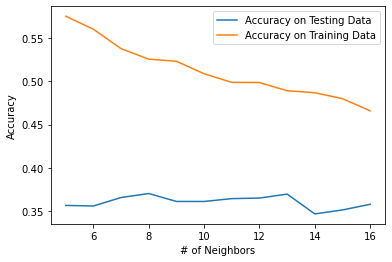

In [77]:
neighbor_number_search(xnn_train,xnn_test,ynn_train,ynn_test,5,17)

###### K Nearest Neighbors Summary

K Nearest Neighbors did not perform particularly well, even on the training data. After attempts at hyperparamater tuning I did not find any further success. With this in mind I am going to move on from attempts modeling with KNN moving forward.

### Penalized Logistic Regression

In [78]:
from text_classification_functions import train_logistic_reg

#### 3 Risks

In [79]:
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_logistic_reg(combined_texts,risk_labels,'l2',1,1000)

In [80]:
lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)

In [81]:
print(f"A penalized logistic regression model classifying risk has an accuracy of {plr_score}\n")
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.6060013046314416

Classification Report:
              precision    recall  f1-score   support

        high       0.69      0.75      0.72       552
         low       0.64      0.46      0.54       400
         mod       0.51      0.56      0.54       581

    accuracy                           0.61      1533
   macro avg       0.61      0.59      0.60      1533
weighted avg       0.61      0.61      0.60      1533



#### High vs Mod + Low

In [82]:
ho_model, ho_lrx_train, ho_lrx_test, ho_lry_train, ho_lry_test \
= train_logistic_reg(high_other_comb_texts, high_other_labels, 'l2', 1, 1000)

In [83]:
ho_lry_pred = ho_model.predict(ho_lrx_test)
ho_score = accuracy_score(ho_lry_test, ho_lry_pred)

In [84]:
print(f"The model accuracy is {ho_score}")
print(" \nClassification Report:")
print(classification_report(ho_lry_test, ho_lry_pred))

The model accuracy is 0.7964774951076321
 
Classification Report:
              precision    recall  f1-score   support

        high       0.77      0.62      0.69       552
       other       0.81      0.90      0.85       981

    accuracy                           0.80      1533
   macro avg       0.79      0.76      0.77      1533
weighted avg       0.79      0.80      0.79      1533



### Random Forest 

In [85]:
from text_classification_functions import train_random_forest, best_random_forest

In [86]:
rf_classifier,rfx_train, rfx_test, rfy_train, rfy_test = train_random_forest(combined_texts,risk_labels)

In [87]:
rfy_pred = rf_classifier.predict(rfx_test)
rf_accuracy = accuracy_score(rfy_test, rfy_pred)
print("Accuracy:", rf_accuracy)

Accuracy: 0.5649054142204827


In [88]:
 print("Classification Report:\n", classification_report(rfy_test, rfy_pred))

Classification Report:
               precision    recall  f1-score   support

        high       0.63      0.78      0.70       552
         low       0.66      0.30      0.41       400
         mod       0.47      0.55      0.51       581

    accuracy                           0.56      1533
   macro avg       0.59      0.54      0.54      1533
weighted avg       0.58      0.56      0.55      1533



Now, I try some hyperparamater tuning to see if model performance can be improved without overfitting.

In [89]:
#best_rf_classifier, rfx_train, rfx_test, rfy_train, rfy_test = best_random_forest(combined_texts, risk_labels)
#rfy_pred = best_rf_classifier.predict(rfx_test)
#brf_accuracy = accuracy_score(rfy_test, rfy_pred)
#print("Best Model Accuracy:", brf_accuracy)
#print("Best Model Parameters:", best_rf_classifier.get_params())

### Ensemble

In [90]:
x = vectorizer.fit_transform(combined_texts)
y = risk_labels.tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)

#### Base Models

#####  Naive Bayes

In [91]:
en_nb_classifier,*_ = train_nb_classifier(combined_texts,risk_labels,.2)

y_pred_nb = en_nb_classifier.predict(x_test)

classification_rep = classification_report(y_test, y_pred_nb)

print("Classification Report for Naive Bayes Classifier:")
print(classification_rep)

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

        high       0.63      0.81      0.71       552
         low       0.56      0.01      0.02       400
         mod       0.46      0.64      0.53       581

    accuracy                           0.54      1533
   macro avg       0.55      0.49      0.42      1533
weighted avg       0.55      0.54      0.46      1533



In [92]:
en_bestalpha_nb_classifier, *_ = train_nb_classifier(combined_texts,risk_labels,.2,.1)

y_pred_nb = en_bestalpha_nb_classifier.predict(x_test)

classification_rep = classification_report(y_test, y_pred_nb)

print("Classification Report for Naive Bayes Classifier:")
print(classification_rep)

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

        high       0.64      0.71      0.67       552
         low       0.58      0.29      0.39       400
         mod       0.47      0.58      0.52       581

    accuracy                           0.55      1533
   macro avg       0.56      0.53      0.53      1533
weighted avg       0.56      0.55      0.54      1533



##### Random Forest

In [93]:
en_rf_classifier, *_ = train_random_forest(combined_texts, risk_labels,750) 

###### Penalized Logistic Regression

In [94]:
en_plr_model, *_ = train_logistic_reg(combined_texts,risk_labels)

#### Stacker Model

In [95]:
estimators = [('PLR',en_plr_model),('RF', en_rf_classifier), ('NB', en_nb_classifier), ('NB_alpha', en_bestalpha_nb_classifier)]
stacker = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacker.fit(x_train,y_train)

StackingClassifier(estimators=[('PLR',
                                LogisticRegression(C=1, max_iter=500,
                                                   random_state=2)),
                               ('RF',
                                RandomForestClassifier(n_estimators=750,
                                                       random_state=2)),
                               ('NB', MultinomialNB()),
                               ('NB_alpha', MultinomialNB(alpha=0.1))],
                   final_estimator=LogisticRegression())

In [96]:
stack_pred = stacker.predict(x_test)

stack_score = accuracy_score(y_test, stack_pred)

stack_score

0.6353555120678408

### Flip It Around

Here I am going to use risk to try to predict text.

### Insights

#### Best Performing Method

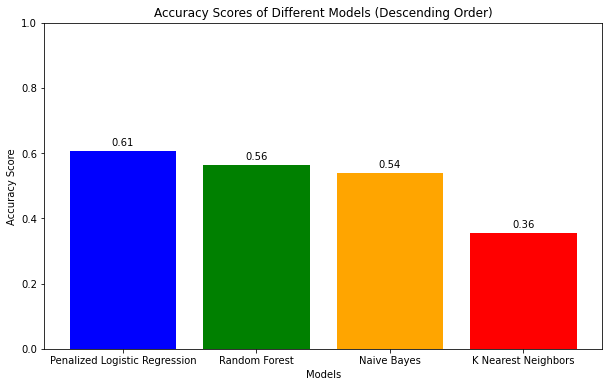

In [97]:
model_names = ['Naive Bayes', 'K Nearest Neighbors', 'Penalized Logistic Regression', 'Random Forest']
accuracy_scores = [nb_accuracy, knn_score, plr_score, rf_accuracy]

sorted_indices = sorted(range(len(accuracy_scores)), key=lambda k: accuracy_scores[k], reverse=True)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracy_scores = [accuracy_scores[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_model_names, sorted_accuracy_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Accuracy Scores of Different Models (Descending Order)')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1) 

for i, v in enumerate(sorted_accuracy_scores):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

#### Important Features

#### Closing Thoughts

## Relative Risk Decision and rrf_notes

In [98]:
rrf_texts = data['rrf_notes']

In [99]:
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_logistic_reg(rrf_texts,risk_labels,'l2',1,1000)

In [100]:
lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)
print(f"A penalized logistic regression model classifying risk has an accuracy of {plr_score}\n")
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.49510763209393344

Classification Report:
              precision    recall  f1-score   support

        high       0.56      0.60      0.58       552
         low       0.53      0.30      0.39       400
         mod       0.43      0.53      0.47       581

    accuracy                           0.50      1533
   macro avg       0.51      0.48      0.48      1533
weighted avg       0.50      0.50      0.49      1533



In [101]:
nb_classifier, x_nb_train, x_nb_test, \
y_nb_train, y_nb_test = train_nb_classifier(rrf_texts,risk_labels,.2,1,2);

In [102]:
y_nb_pred = nb_classifier.predict(x_nb_test)
y_nb_train_pred = nb_classifier.predict(x_nb_train)

nb_accuracy = accuracy_score(y_nb_test, y_nb_pred)

print(f"The Naive Bayes classifier accuracy is {nb_accuracy:.4f} or {nb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_nb_test, y_nb_pred))

The Naive Bayes classifier accuracy is 0.4618 or 46.18%


Classification Report:
              precision    recall  f1-score   support

        high       0.48      0.76      0.59       552
         low       0.60      0.07      0.13       400
         mod       0.42      0.45      0.44       581

    accuracy                           0.46      1533
   macro avg       0.50      0.43      0.38      1533
weighted avg       0.49      0.46      0.41      1533



###  Choosing a Model

In [103]:
# # Example usage
# best_model, reports_df, comparison_df = train_and_evaluate_models_v3(combined_texts, risk_labels)
# print("Best Model:", best_model)


### Tuning the Model

## Individual Risk Category Decisions

# Risk Classification - N-Grams

In [104]:
from text_classification_functions import try_variety_of_models
from text_analysis_functions_wagers import vectorize_text_with_ngrams

## Bigrams

In [ ]:
ngram_range = (1, 2)    # You can adjust the n-gram range as needed
ng_x_train_tfidf, ng_x_test_tfidf, ng_y_train, ng_y_test = vectorize_text_with_ngrams(combined_texts, risk_labels, ngram_range=ngram_range, test_size=0.2)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(ng_x_train_tfidf, ng_y_train)

ng_y_pred = nb_classifier.predict(ng_x_test_tfidf)

accuracy = accuracy_score(ng_y_test, ng_y_pred)
print("Accuracy:", accuracy)


print("Classification Report:")
print(classification_report(ng_y_test, ng_y_pred))

In [ ]:
from scipy.sparse import hstack
logistic_reg = LogisticRegression(random_state=2)
logistic_reg.fit(ng_x_train_tfidf, ng_y_train)

# Make predictions on the test set
ng_y_pred = logistic_reg.predict(ng_x_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(ng_y_test, ng_y_pred)
print("Accuracy:", accuracy)

In [ ]:
ngram_rf = RandomForestClassifier(random_state=2)
ngram_rf.fit(ng_x_train_tfidf,ng_y_train)

ngram_rf_pred = ngram_rf.predict(ng_x_test_tfidf)

accuracy = accuracy_score(ng_y_test, ngram_rf_pred)

In [ ]:
accuracy

In [ ]:
results = try_variety_of_models(ng_x_train_tfidf, ng_y_train, ng_x_test_tfidf, ng_y_test)

# Print the results
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print("Cross-Validation Scores:", result['Cross-Validation Scores'])
    print("Test Set Classification Report:")
    print(result['Test Set Classification Report'])
    print("\n")

## Trigrams

In [ ]:
ngram_range = (1, 3)    # You can adjust the n-gram range as needed
trig_x_train_tfidf, trig_x_test_tfidf, trig_y_train, trig_y_test = vectorize_text_with_ngrams(combined_texts, risk_labels, ngram_range=ngram_range, test_size=0.2)

In [ ]:
results = try_variety_of_models(trig_x_train_tfidf, trig_y_train, trig_x_test_tfidf, trig_y_test)

# Print the results
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print("Cross-Validation Scores:", result['Cross-Validation Scores'])
    print("Test Set Classification Report:")
    print(result['Test Set Classification Report'])
    print("\n")

In [ ]:
ngram_range = (1, 5)
fivegram_x_train_tfidf, fivegram_x_test_tfidf, fivegram_y_train, fivegram_y_test = vectorize_text_with_ngrams(combined_texts, risk_labels, ngram_range=ngram_range, test_size=0.2)


In [ ]:
results_fivegram = try_variety_of_models(fivegram_x_train_tfidf, fivegram_y_train, fivegram_x_test_tfidf, fivegram_y_test)

# Print the results
for model_name, result in results_fivegram.items():
    print(f"Results for {model_name} with 5-grams:")
    print("Cross-Validation Scores:", result['Cross-Validation Scores'])
    print("Test Set Classification Report:")
    print(result['Test Set Classification Report'])
    print("\n")

# SVOs

In [104]:
import spacy
from subject_object_extraction import findSVOs

# Download the English model
spacy.cli.download("en_core_web_sm")
parser = spacy.load('en_core_web_sm')
svo_data = data.copy()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [105]:
svo_data['combined_text_svo'] = ''

for index, row in svo_data.iterrows():
    text = row['combined_text']
    parsed_text = parser(text)
    svos = findSVOs(parsed_text)
    svo_data.at[index, 'combined_text_svo'] = svos
    

In [106]:
svo_data

,wfdss_risk,wfdss_org_id,wfdss_id,orgneed_id,rr_id,fire_name,latitude,longitude,geographic_area,geo_area_name,...,rrf_values_desc,rrf_rr_desc_1,orgf_org_value_desc,orgf_org_value_desc2,orgf_notes,disttowild,name,acreage,combined_text,combined_text_svo
0,1129395 - mod,1129395-1137632,1129395,1137632,1137625.0,Buck #1,29.92550,-84.94720,1,Southern,...,low,mod,T3 Organization,Type 3,based relative organizational needs indicated ...,13729.609590,Mud Swamp/New River Wilderness,8075.0,fuel conditions close based lack control lines...,"[(conditions, persist, behavior), (conditions,..."
1,1145279 - high,1145279-1145712,1145279,1145712,1145711.0,49er,34.84439,-92.80926,1,Southern,...,mod,high,Short T2 IMT,Type 2,type organization available final estimated si...,7723.559640,Flatside Wilderness,10180.0,rugged terrain parts starting remote indirect ...,"[(parts, starting, tactics), (tactics, using, ..."
2,1145279 - mod,1145279-1145720,1145279,1145720,1145719.0,49er,34.84439,-92.80926,1,Southern,...,mod,mod,T3 Organization,Type 3,,7723.559640,Flatside Wilderness,10180.0,predicted winds put smoke little rock,"[(winds, put, smoke)]"
3,1148295 - mod,1148295-1148479,1148295,1148479,1148477.0,Clear-Cut,26.21003,-81.36806,1,Southern,...,low,mod,T3 Organization,Type 3,managed type qualified type type helicopter sa...,35199.123460,Marjory Stoneman Douglas Wilderness,1296500.0,behavior mainly creeping hardwood hits torches...,"[(behavior, creeping, hardwood), (torches, thr..."
4,1154074 - mod,1154074-1157125,1154074,1157125,1157122.0,Hopkins Prairie,29.28650,-81.71430,1,Southern,...,mod,mod,T3 Organization,Type 3,although indicies measures ensure containment ...,4272.071047,Juniper Prairie Wilderness,14293.0,smoldering active unburned fuel lines continue...,"[(smoldering, continues, structures), (activit..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660,864752 - low,864752-865386,864752,865386,865381.0,Raspberry Mountain,34.38083,-93.99472,1,Southern,...,low,low,T3 Organization,Type 3,type ic assigned daily complexity analysis tim...,1953.154026,Caney Creek Wilderness,14262.0,fuel model steep trending mountain slope sprea...,"[(model, trending, slope), (months, scattered,..."
7661,867259 - low,867259-868253,867259,868253,868252.0,Skegg Again,37.25854,-82.34452,1,Southern,...,low,low,T3 Organization,Type 3,although functional primarily difficult access...,68002.602360,Stone Mountain Wilderness,3273.0,although weeks since last abnormally dry accor...,"[(winds, distance, homes), (homes, distance, h..."
7662,867259 - mod,867259-867920,867259,867920,867919.0,Skegg Again,37.25854,-82.34452,1,Southern,...,mod,mod,Short T2 IMT,Type 2,,68002.602360,Stone Mountain Wilderness,3273.0,primary homes forecast winds remain homes im...,"[(winds, remain, homes), (rain, considered, fo..."
7663,867813 - mod,867813-868713,867813,868713,868670.0,MORU WILDFIRE,43.87558,-103.44956,2,Rocky Mountain,...,low,mod,T3 Organization,Type 3,strong type organization staff functions fille...,841.695208,Black Elk Wilderness,13534.0,surface torching slash heavy fuels become stan...,"[(surface, torching, fuels), (surface, become,..."


In [107]:
svos = svo_data['combined_text_svo']
labels = svo_data['rrf_rr_desc']

svo_strings = [' '.join(map(str, svo)) for svo in svos]

subjects = [' '.join([svo[0] for svo in svo_pair]) for svo_pair in svos]
verbs = [' '.join([svo[1] for svo in svo_pair]) for svo_pair in svos]
objects = [' '.join([svo[2] for svo in svo_pair]) for svo_pair in svos]


In [108]:
assert len(subjects) == len(labels), "Inconsistent lengths of subjects and labels"

In [109]:
for risk_category in labels.unique():
    print(f"\nTop SVOs for Risk Category: {risk_category}")
    
    # Filter rows for the current risk category
    rows_for_risk = svo_data[labels == risk_category]
    
    # Flatten the list of SVOs for these rows
    all_svos = [svo for svo_pair in rows_for_risk['combined_text_svo'] for svo in svo_pair]
    
    # Get the most common SVOs and their counts
    most_common_svos = Counter(all_svos).most_common(5)  # Change 5 to the desired number of top SVOs
    
    # Print the most common SVOs and their counts
    for svo, count in most_common_svos:
        print(f"{svo}: {count} occurrences")


Top SVOs for Risk Category: mod
('season', 'ending', 'event'): 103 occurrences
('terrain', 'pose', 'problems'): 29 occurrences
('range', 'spotting', 'rates'): 28 occurrences
('barriers', 'spread', 'barriers'): 25 occurrences
('barriers', 'spread', 'fuels'): 19 occurrences

Top SVOs for Risk Category: high
('season', 'ending', 'event'): 135 occurrences
('operations', 'taking', 'place'): 85 occurrences
('range', 'spotting', 'rates'): 52 occurrences
('barriers', 'spread', 'barriers'): 52 occurrences
('action', 'supporting', 'units'): 42 occurrences

Top SVOs for Risk Category: low
('season', 'ending', 'event'): 98 occurrences
('smoke', 'turned', 'unit'): 18 occurrences
('support', 'use', 'role'): 16 occurrences
('barriers', 'spread', 'barriers'): 15 occurrences
('season', 'ending', 'events'): 12 occurrences


In [110]:
all_svos = [svo for svo_pair in svos for svo in svo_pair]
overall_counts = Counter(all_svos)

cutoff_threshold = 0.9

# Iterate through unique risk categories
for risk_category in labels.unique():
    print(f"\nTop Disproportionately Common SVOs for Risk Category: {risk_category}")
    
    # Filter rows for the current risk category
    rows_for_risk = svo_data[labels == risk_category]
    
    # Flatten the list of SVOs for these rows
    svo_counts_for_risk = [svo for svo_pair in rows_for_risk['combined_text_svo'] for svo in svo_pair]
    
    # Calculate the distribution of SVOs within the current risk category
    counts_for_risk = Counter(svo_counts_for_risk)
    
    # Calculate the relative frequencies and find disproportionately common SVOs
    disproportionate_svos = {
        svo: (count / overall_counts[svo]) for svo, count in counts_for_risk.items()
        if overall_counts[svo] > 0 and (count / overall_counts[svo]) <= cutoff_threshold
    }
    
    # Sort and print the most disproportionately common SVOs
    for svo, relative_frequency in sorted(disproportionate_svos.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{svo}: Relative Frequency {relative_frequency:.4f}")


Top Disproportionately Common SVOs for Risk Category: mod
('cooperators', 'neighboring', 'neighbors'): Relative Frequency 0.9000
('frequency', 'iaps', 'issues'): Relative Frequency 0.8750
('activity', 'projected', 'part'): Relative Frequency 0.8750
('smoke', 'reduce', 'infrastructure'): Relative Frequency 0.8750
('number', 'using', 'agency'): Relative Frequency 0.8571

Top Disproportionately Common SVOs for Risk Category: high
('levels', 'varied', 'frequency'): Relative Frequency 0.9000
('effectiveness', 'needed', 'measures'): Relative Frequency 0.9000
('actions', 'required', 'agency'): Relative Frequency 0.9000
('operations', 'taking', 'place'): Relative Frequency 0.8947
('rates', 'spread', 'growth'): Relative Frequency 0.8889

Top Disproportionately Common SVOs for Risk Category: low
('growth', 'remain', 'category'): Relative Frequency 0.8889
('option', 'share', 'managing'): Relative Frequency 0.8750
('discussions', 'taken', 'wildlife'): Relative Frequency 0.8571
('option', 'share',

In [111]:
# Split the data into training and testing sets for subjects
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(subjects, labels, test_size=0.2, random_state=2)

# Use TF-IDF vectorization for subjects
tfidf_vectorizer_sub = TfidfVectorizer()
x_train_tfidf_sub = tfidf_vectorizer_sub.fit_transform(x_train_sub)
x_test_tfidf_sub = tfidf_vectorizer_sub.transform(x_test_sub)

# Create a Logistic Regression model for subjects
model_sub = LogisticRegression(random_state=2)
model_sub.fit(x_train_tfidf_sub, y_train_sub)
y_pred_sub = model_sub.predict(x_test_tfidf_sub)
accuracy_sub = accuracy_score(y_test_sub, y_pred_sub)
report_sub = classification_report(y_test_sub, y_pred_sub)

# Display evaluation metrics for Subjects
print("\n### Subjects ###")
print(f"Accuracy: {accuracy_sub:.2f}")
print("Classification Report:\n", report_sub)


# Split the data into training and testing sets for verbs
x_train_verb, x_test_verb, y_train_verb, y_test_verb = train_test_split(verbs, labels, test_size=0.2, random_state=2)

# Use TF-IDF vectorization for verbs
tfidf_vectorizer_verb = TfidfVectorizer()
x_train_tfidf_verb = tfidf_vectorizer_verb.fit_transform(x_train_verb)
x_test_tfidf_verb = tfidf_vectorizer_verb.transform(x_test_verb)

# Create a Logistic Regression model for verbs
model_verb = LogisticRegression(random_state=2)
model_verb.fit(x_train_tfidf_verb, y_train_verb)
y_pred_verb = model_verb.predict(x_test_tfidf_verb)
accuracy_verb = accuracy_score(y_test_verb, y_pred_verb)
report_verb = classification_report(y_test_verb, y_pred_verb)

# Display evaluation metrics for Verbs
print("\n### Verbs ###")
print(f"Accuracy: {accuracy_verb:.2f}")
print("Classification Report:\n", report_verb)


# Split the data into training and testing sets for objects
x_train_obj, x_test_obj, y_train_obj, y_test_obj = train_test_split(objects, labels, test_size=0.2, random_state=2)

# Use TF-IDF vectorization for objects
tfidf_vectorizer_obj = TfidfVectorizer()
x_train_tfidf_obj = tfidf_vectorizer_obj.fit_transform(x_train_obj)
x_test_tfidf_obj = tfidf_vectorizer_obj.transform(x_test_obj)

# Create a Logistic Regression model for objects
model_obj = LogisticRegression(random_state=2)
model_obj.fit(x_train_tfidf_obj, y_train_obj)
y_pred_obj = model_obj.predict(x_test_tfidf_obj)
accuracy_obj = accuracy_score(y_test_obj, y_pred_obj)
report_obj = classification_report(y_test_obj, y_pred_obj)

# Display evaluation metrics for Objects
print("\n### Objects ###")
print(f"Accuracy: {accuracy_obj:.2f}")
print("Classification Report:\n", report_obj)


### Subjects ###
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

        high       0.52      0.57      0.54       552
         low       0.39      0.23      0.29       400
         mod       0.42      0.50      0.45       581

    accuracy                           0.45      1533
   macro avg       0.44      0.43      0.43      1533
weighted avg       0.45      0.45      0.44      1533


### Verbs ###
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

        high       0.50      0.55      0.52       552
         low       0.43      0.24      0.31       400
         mod       0.40      0.49      0.44       581

    accuracy                           0.45      1533
   macro avg       0.44      0.43      0.42      1533
weighted avg       0.45      0.45      0.44      1533


### Objects ###
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

        high    

In [112]:
x_train, x_test, y_train, y_test = train_test_split(svo_strings, labels, test_size=0.2, random_state=2)

tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)


In [113]:
model = RandomForestClassifier()

model.fit(x_train_tfidf, y_train)

y_pred = model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

        high       0.54      0.65      0.59       552
         low       0.53      0.24      0.33       400
         mod       0.42      0.51      0.46       581

    accuracy                           0.49      1533
   macro avg       0.50      0.47      0.46      1533
weighted avg       0.50      0.49      0.47      1533



# Final Model and Insights

## Best Individual Model - Penalized Logistic Regression

In [114]:
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_logistic_reg(combined_texts,risk_labels,'l2',1.1,1000)

lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)

print(f"A penalized logistic regression model classifying risk has an accuracy of {plr_score}\n")
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.6033920417482062

Classification Report:
              precision    recall  f1-score   support

        high       0.69      0.75      0.72       552
         low       0.62      0.46      0.53       400
         mod       0.51      0.56      0.53       581

    accuracy                           0.60      1533
   macro avg       0.61      0.59      0.60      1533
weighted avg       0.61      0.60      0.60      1533



In [115]:
report_dict = classification_report(lry_test, lry_pred, output_dict=True)

# Convert the classification report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to whatever you prefer
report_df.rename(columns={'index': 'metrics'}, inplace=True)
# Add a new row for the model accuracy at the end of the DataFrame
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame
final_report_df4 = pd.concat([report_df, accuracy_row])


# Print the DataFrame to ensure it looks correct
print(final_report_df4)

final_report_df4.to_csv("threeclassreport.csv")

               metrics  precision    recall  f1-score      support
0                 high   0.691030  0.753623  0.720971   552.000000
1                  low   0.625000  0.462500  0.531609   400.000000
2                  mod   0.510236  0.557659  0.532895   581.000000
3             accuracy   0.603392  0.603392  0.603392     0.603392
4            macro avg   0.608755  0.591261  0.595158  1533.000000
5         weighted avg   0.605281  0.603392  0.600281  1533.000000
accuracy           NaN        NaN       NaN  0.796477          NaN


### Insights

In [116]:
feature_names = vectorizer.get_feature_names_out()

coefficients = plr_model.coef_

num_top_features = 20
for class_index, class_name in enumerate(plr_model.classes_):

    class_coefficients = coefficients[class_index]

    top_feature_indices = np.argsort(class_coefficients)[-num_top_features:][::-1]

    top_features = [feature_names[i] for i in top_feature_indices]

    print(f"Top features for class '{class_name}':")
    for feature in top_features:
        coefficient_value = class_coefficients[np.where(feature_names == feature)[0][0]]  # Get the coefficient value
        print(f"- {feature}: {coefficient_value:.4f}")
    print("\n")


Top features for class 'high':
- extreme: 3.9464
- dry: 2.6941
- structures: 2.3348
- difficult: 2.0321
- large: 1.9933
- continuous: 1.9717
- team: 1.9574
- record: 1.7920
- state: 1.7695
- homes: 1.7367
- availability: 1.7285
- spotting: 1.7110
- imt: 1.6947
- crown: 1.6884
- long: 1.6599
- throughout: 1.6411
- evacuations: 1.5379
- drought: 1.5169
- communities: 1.5147
- private: 1.4996


Top features for class 'low':
- minimal: 3.2678
- monitor: 2.3398
- precipitation: 2.2201
- sparse: 1.9610
- monitoring: 1.9457
- surrounded: 1.9362
- little: 1.9046
- late: 1.8475
- fall: 1.8441
- reduced: 1.7946
- smoldering: 1.7719
- contained: 1.7648
- repair: 1.7197
- monitored: 1.6926
- snow: 1.6850
- rain: 1.6716
- moisture: 1.6268
- elevation: 1.6131
- received: 1.6087
- monsoonal: 1.5831


Top features for class 'mod':
- still: 1.6637
- consists: 1.4142
- scars: 1.3709
- average: 1.2759
- away: 1.1493
- vegetation: 1.1411
- solely: 1.0872
- mitigated: 1.0593
- sufficient: 1.0435
- adequate

In [124]:
def store_coefficients(vectorizer, plr_model, num_features=15, filename='coefficients_across_classes.csv'):
    feature_names = vectorizer.get_feature_names_out()
    coefficients = plr_model.coef_

    # Identify the top and bottom 15 features for each class
    top_bottom_features = set()
    for class_index in range(len(plr_model.classes_)):
        top_indices = np.argsort(coefficients[class_index])[-num_features:][::-1]
        bottom_indices = np.argsort(coefficients[class_index])[:num_features]
        top_bottom_features.update(top_indices)
        top_bottom_features.update(bottom_indices)

    # Convert set to list to index features
    top_bottom_feature_indices = list(top_bottom_features)

    # Prepare to write to CSV
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Header row with class names for coefficients
        header = ['Feature'] + [f'Coefficient_{class_name}' for class_name in plr_model.classes_]
        writer.writerow(header)

        # Write the coefficients for each top and bottom feature across all classes
        for idx in top_bottom_feature_indices:
            feature = feature_names[idx]
            # Retrieve the coefficient of this feature across all classes
            coeffs_across_classes = [coefficients[class_index][idx] for class_index in range(len(plr_model.classes_))]
            row = [feature] + [f'{coeff:.4f}' for coeff in coeffs_across_classes]
            writer.writerow(row)

In [126]:
store_coefficients(vectorizer=vectorizer, plr_model=plr_model, num_features=8)

## Best Ensemble - Stacker

In [286]:
best_nb_classifier, *_ = train_nb_classifier(combined_texts,risk_labels,.2,.1)

In [287]:
estimators = [('PLR',plr_model),('RF', en_rf_classifier), ('NB_alpha', best_nb_classifier)]

In [288]:
stacker = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacker.fit(lrx_train,lry_train)
;

''

In [289]:
stack_pred = stacker.predict(lrx_test)

stack_score = accuracy_score(lry_test, stack_pred)

stack_score

0.6333985649054142

# How Does Text Change Across Agency Involvement?

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import pearsonr
from agency_involvement_functions import get_most_common_words, analyze_agency_involvement, get_agency_stats, pretty_print_results

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [116]:
agencies = ['usfs', 'ancsa', 'blm', 'bia_tribal', 'c_l', 'nps', 'other', 'state', 'usfws', 'doi', 'federal']

In [117]:
data_copy = data.copy()

In [118]:
agency_involvement = analyze_agency_involvement(data_copy, agencies)
agency_involvement;

C:\Users\aidan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Overview Data

###### Percentage Involvement

The below chart visualizes the percentage of risk-report entries that have a positive value for a given agencies involvement. It is noteworthy that 98% of fires have some amount of federal involvement. Roughly two-thirds of fires have U.S. Forest Service (USFS) involvement, and roughly half have Department of The Interior (DOI) involvement. The other agencies have a much smaller share of reports, ranging from roughly 3% to roughly 33% of fire-risk combinations.

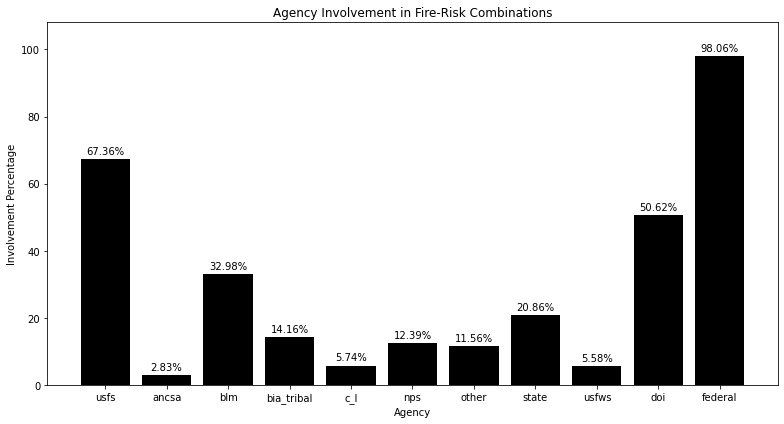

In [122]:
involvement_percentages = {agency: data['involvement_percentage'] for agency, data in agency_involvement.items()}

agencies = list(involvement_percentages.keys())
percentages = list(involvement_percentages.values())

fig, ax = plt.subplots(figsize=(11, 6))
bars = ax.bar(agencies, percentages, color='#000000')

# Adding labels and title
ax.set_xlabel('Agency')
ax.set_ylabel('Involvement Percentage')
ax.set_title('Agency Involvement in Fire-Risk Combinations')
ax.set_ylim(0, max(percentages) + 10)  

# Adding percentage labels above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

###### Prediction Accuracy

The below chart plots the accuracy of a logistic regression model at predicting whether or not an agency is involved in a fire report using the text for a fire. This was fairly succesful! The model predicts at between 79% and 98% accuracy across agencies. Later, we will use the feature-coefficient pairings to determine the features that are potentially predictive of agency involvement in a given fire.

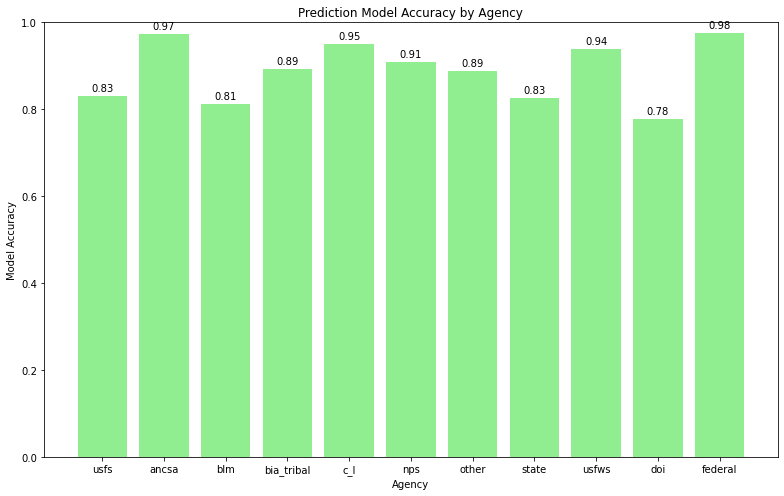

In [123]:
model_accuracies = {agency: data['model_performance']['accuracy'] for agency, data in agency_involvement.items()}
agencies = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Creating a bar chart for model accuracies
fig, ax = plt.subplots(figsize=(11,7))
bars = ax.bar(agencies, accuracies, color='lightgreen')

# Adding labels and title
ax.set_xlabel('Agency')
ax.set_ylabel('Model Accuracy')
ax.set_title('Prediction Model Accuracy by Agency')
ax.set_ylim(0, 1)  # Accuracy range is 0 to 1

# Adding accuracy labels above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

###### Multi-Jurisdictional Fires

In the cell below, the percentage of fires that are multi-jurisdictional (defined here as having involvement from more than one agency). This is the vast majority of fires.

In [124]:
data['multi-jurisdictional'] = data.apply(lambda row: 1 if sum(row[col] >= 1 for \
col in ['usfs', 'ancsa', 'blm', 'bia_tribal', 'c_l', 'nps', 'other', 'state', 'usfws', 'doi', 'federal']) \
> 1 else 0, axis=1)

percentage_multi_jurisdictional = (data['multi-jurisdictional'].sum() / len(data)) * 100

print(f"{percentage_multi_jurisdictional}")

98.52576647097196


## Agency Specific Insights

In [125]:
flattened_data = defaultdict(list)

for key, value in agency_involvement.items():
    # Initialize/reset a temporary dictionary for the current row
    temp_dict = defaultdict(list)
    
    # Assign the agency name for the current row
    temp_dict['agency'] = [key]
    
    # Iterate through the nested dictionaries
    for sub_key, sub_value in value.items():
        if isinstance(sub_value, dict):
            for sub_sub_key, sub_sub_value in sub_value.items():
                if isinstance(sub_sub_value, list):
                    # Assuming we want to capture lists as they are, consider how to represent them
                    # Here, we append the whole list for simplicity; adjust based on your needs
                    temp_dict[sub_sub_key].append(sub_sub_value)
                else:
                    temp_dict[sub_sub_key].append(sub_sub_value)
        else:
            temp_dict[sub_key].append(sub_value)
    
    # Now, merge temp_dict into flattened_data, ensuring each key gets its corresponding value
    for temp_key, temp_value in temp_dict.items():
        flattened_data[temp_key].extend(temp_value)

# Convert the flattened dictionary to a DataFrame
flat = pd.DataFrame(flattened_data)

In [126]:
flat['agency'] = flat['agency'].astype(str)

In [127]:
flat

,agency,involvement_percentage,common_words_present,common_words_absent,relative_freq_present,relative_freq_absent,sorted_comparative_freq,accuracy,precision,recall,f1,positive,negative
0,usfs,67.358121,"[(fuel, 9100), (private, 7646), (fuels, 7256),...","[(fuel, 3315), (fuels, 2900), (spread, 2460), ...","{'fuel': 0.1405513939300332, 'private': 0.1180...","{'fuel': 0.1458360828824073, 'fuels': 0.127579...","[(private, 0.11809406131747625), (suppression,...",0.830398,0.814575,0.970106,0.885563,"[{'Feature': 'fs', 'Coefficient': 4.1635490661...","[{'Feature': 'spruce', 'Coefficient': -2.36156..."
1,ancsa,2.831050,"[(native, 463), (spread, 358), (protection, 35...","[(fuel, 12185), (fuels, 9830), (private, 9247)...","{'native': 0.14211172498465316, 'spread': 0.10...","{'fuel': 0.1438165380166655, 'fuels': 0.116021...","[(fuel, -0.1438165380166655), (native, 0.14211...",0.973255,1.000000,0.068182,0.127660,"[{'Feature': 'native', 'Coefficient': 5.539224...","[{'Feature': 'cultural', 'Coefficient': -0.671..."
2,blm,32.981083,"[(fuel, 4992), (private, 4345), (fuels, 4026),...","[(fuel, 7423), (fuels, 6130), (spread, 5554), ...","{'fuel': 0.14242510699001426, 'private': 0.123...","{'fuel': 0.14024977799610786, 'fuels': 0.11581...","[(suppression, 0.09426533523537803), (incident...",0.811481,0.837545,0.487395,0.616202,"[{'Feature': 'blm', 'Coefficient': 9.584882465...","[{'Feature': 'close', 'Coefficient': -1.662836..."
3,bia_tribal,14.155251,"[(fuel, 1965), (fuels, 1762), (suppression, 15...","[(fuel, 10450), (fuels, 8394), (private, 8110)...","{'fuel': 0.1334737128107594, 'fuels': 0.119684...","{'fuel': 0.14264458974323974, 'fuels': 0.11457...","[(suppression, 0.10528460806955577), (weather,...",0.893020,0.846154,0.302752,0.445946,"[{'Feature': 'tribal', 'Coefficient': 7.157142...","[{'Feature': 'type', 'Coefficient': -1.2012563..."
4,c_l,5.740378,"[(fuel, 776), (private, 712), (fuels, 579), (s...","[(fuel, 11639), (fuels, 9577), (private, 8614)...","{'fuel': 0.14341156902605803, 'private': 0.131...","{'fuel': 0.14172816054163317, 'fuels': 0.11661...","[(suppression, 0.10534097209388284), (season, ...",0.949772,0.000000,0.000000,0.000000,"[{'Feature': 'structures', 'Coefficient': 2.47...","[{'Feature': 'smoke', 'Coefficient': -0.891464..."
5,nps,12.393999,"[(fuel, 1729), (fuels, 1443), (behavior, 1395)...","[(fuel, 10686), (fuels, 8713), (private, 8395)...","{'fuel': 0.13631346578366446, 'fuels': 0.11376...","{'fuel': 0.14252370727022953, 'fuels': 0.11620...","[(private, -0.11196767008549288), (growth, 0.0...",0.909328,0.980392,0.265957,0.418410,"[{'Feature': 'park', 'Coefficient': 9.36031907...","[{'Feature': 'team', 'Coefficient': -1.1221569..."
6,other,11.559035,"[(fuel, 1435), (private, 1393), (fuels, 1144),...","[(fuel, 10980), (fuels, 9012), (spread, 8048),...","{'fuel': 0.14032857422256992, 'private': 0.136...","{'fuel': 0.14201458947695172, 'fuels': 0.11656...","[(suppression, 0.09867005671816938), (time, -0...",0.887802,0.750000,0.017241,0.033708,"[{'Feature': 'jurisdictions', 'Coefficient': 1...","[{'Feature': 'old', 'Coefficient': -1.32825025..."
7,state,20.861057,"[(fuel, 3239), (fuels, 2826), (private, 2636),...","[(fuel, 9176), (fuels, 7330), (spread, 6722), ...","{'fuel': 0.13507089241034195, 'fuels': 0.11784...","{'fuel': 0.14390790897542463, 'fuels': 0.11495...","[(suppression, 0.09603836530442035), (time, -0...",0.825832,0.761905,0.205788,0.324051,"[{'Feature': 'state', 'Coefficient': 4.8350268...","[{'Feature': 'would', 'Coefficient': -1.345329..."
8,usfws,5.583823,"[(spread, 780), (fuel, 720), (fuels, 676), (ob...","[(fuel, 11695), (fuels, 9480), (private, 8832)...","{'spread': 0.13231552162849872, 'fuel': 0.1221...","{'fuel': 0.1435215865302015, 'fuels': 0.116339...","[(private, -0.10838671673661733), (objectives,...",0.938030,0.500000,0.010526,0.020619,"[{'Feature': 'refuge', 'Coefficient': 4.993842...","[{'Feature': 'minimal', 'Coefficient': -0.8686..."
9,doi,50.619700,"[(fuel, 7015), (fuels, 5727), (spread, 5

### National Park Service

In [128]:
ancsa_results = get_agency_stats(flat,'nps')
pretty_print_results(ancsa_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 12.39
common_words_present      :
[   ('fuel', 1729),
    ('fuels', 1443),
    ('behavior', 1395),
    ('spread', 1394),
    ('season', 1195),
    ('growth', 1181),
    ('smoke', 1175),
    ('barriers', 1087),
    ('conditions', 1061),
    ('time', 1024)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10686),
    ('fuels', 8713),
    ('private', 8395),
    ('spread', 7679),
    ('season', 7304),
    ('behavior', 7177),
    ('incident', 6421),
    ('time', 6378),
    ('conditions', 6211),
    ('barriers', 6013)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.08569851781772311,
    'behavior': 0.10998107852412488,
    'conditions': 0.08364869126458531,
    'fuel': 0.13631346578366446,
    'fuels': 0.11376537369914853,
    'growth': 0.09310942920214443,
    'se

### ANCSA

In [129]:
ancsa_results = get_agency_stats(flat,'ancsa')
pretty_print_results(ancsa_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 2.83
common_words_present      :
[   ('native', 463),
    ('spread', 358),
    ('protection', 358),
    ('allotments', 335),
    ('conditions', 333),
    ('fuels', 326),
    ('weather', 304),
    ('smoke', 261),
    ('behavior', 261),
    ('season', 259)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 12185),
    ('fuels', 9830),
    ('private', 9247),
    ('spread', 8715),
    ('behavior', 8311),
    ('season', 8240),
    ('time', 7224),
    ('incident', 7125),
    ('conditions', 6939),
    ('barriers', 6910)]
--------------------------------------------------
relative_freq_present     :
{   'allotments': 0.10282381829343155,
    'behavior': 0.08011049723756906,
    'conditions': 0.10220994475138122,
    'fuels': 0.10006138735420503,
    'native': 0.14211172498465316,
    'protection': 0.10988336402701043,

In [130]:
from imblearn.over_sampling import RandomOverSampler

def adress_agency_imbalance(agency, df):
    # Initialize a vectorizer
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2), stop_words='english')
    
    # Prepare the feature matrix and the target vector
    X = vectorizer.fit_transform(df['combined_text'].fillna(''))
    y = df[agency]
    
    # Addressing class imbalance
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Splitting the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Model training with hyperparameter tuning (if needed)
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = lr_model.predict(X_test)
    
    # Generate classification report
    report = classification_report(y_test, y_pred)
    print(report)
    
    # Cross-validation for model evaluation
    cv_scores = cross_val_score(lr_model, X_resampled, y_resampled, cv=5, scoring='accuracy')  # Change scoring as needed
    print("Cross-validated scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    
    # Feature importance analysis
    feature_names = vectorizer.get_feature_names_out()
    coefficients = lr_model.coef_[0]
    feature_coefficients = dict(zip(feature_names, coefficients))
    
    # Sorting feature coefficients for positive and negative classes
    sorted_positive_coefficients = sorted(feature_coefficients.items(), key=lambda x: x[1], reverse=True)[:12]
    sorted_negative_coefficients = sorted(feature_coefficients.items(), key=lambda x: x[1])[:12]
    
    # Printing sorted coefficients
    print("\nSorted positive class feature coefficients:")
    for feature, coefficient in sorted_positive_coefficients:
        print(f"{feature}: {coefficient}")
        
    print("\nSorted negative class feature coefficients:")
    for feature, coefficient in sorted_negative_coefficients:
        print(f"{feature}: {coefficient}")

# Example usage:
# process_agency_classification('agency_column_name', your_dataframe)

In [159]:
def update_agency_stats_and_features(agency, df, stats_file='agency_stats.csv', features_file='agency_features.csv'):
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,1), stop_words='english')
    X = vectorizer.fit_transform(df['combined_text'].fillna(''))
    y = df[agency]
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Load or create the statistics DataFrame
    try:
        stats_df = pd.read_csv(stats_file)
    except FileNotFoundError:
        stats_df = pd.DataFrame(columns=['Agency', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Run Date'])
    
    new_stats = pd.DataFrame([{
        'Agency': agency,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Run Date': pd.Timestamp.now()
    }])
    stats_df = pd.concat([stats_df, new_stats], ignore_index=True)
    stats_df.to_csv(stats_file, index=False)
    
    # Feature coefficients extraction and update
    feature_names = vectorizer.get_feature_names_out()
    coefficients = lr_model.coef_[0]
    feature_data = pd.DataFrame({
        'Agency': [agency]*len(feature_names),
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # Load or create the features DataFrame
    try:
        features_df = pd.read_csv(features_file)
    except FileNotFoundError:
        features_df = pd.DataFrame(columns=['Agency', 'Feature', 'Coefficient'])
    
    features_df = pd.concat([features_df, feature_data], ignore_index=True)
    features_df.to_csv(features_file, index=False)
    
    print(f"Updated statistics for {agency} saved to {stats_file}.")
    print(f"Feature coefficients for {agency} saved to {features_file}.")


In [131]:
adress_agency_imbalance('nps',data_copy)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1354
           1       0.96      0.95      0.96      1332

    accuracy                           0.96      2686
   macro avg       0.96      0.96      0.96      2686
weighted avg       0.96      0.96      0.96      2686

Cross-validated scores: [0.94601638 0.93670886 0.94973939 0.95830231 0.9530901 ]
Mean accuracy: 0.948771407297096

Sorted positive class feature coefficients:
park: 12.708322678372946
nps: 10.11641704814846
lava: 4.487487567940865
yosemite: 3.5818987694777653
yellowstone: 3.0523446617944527
grand: 2.9540099854149258
levels: 2.897243771925879
preserve: 2.661544146412227
crater: 2.405652298696132
cabin: 2.4031391271645344
information: 2.396894697367453
tioga: 2.3634679607721183

Sorted negative class feature coefficients:
timber: -3.9851345576018913
private: -3.300809769225715
type: -2.919216254570788
hunting: -2.877231470066487
suppression: -2.3230923595363233
brush

### Bureau of Land Management

In [132]:
blm_results = get_agency_stats(flat,'blm')
pretty_print_results(blm_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 32.98
common_words_present      :
[   ('fuel', 4992),
    ('private', 4345),
    ('fuels', 4026),
    ('spread', 3519),
    ('suppression', 3304),
    ('behavior', 3139),
    ('incident', 3053),
    ('season', 3007),
    ('conditions', 2838),
    ('time', 2827)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 7423),
    ('fuels', 6130),
    ('spread', 5554),
    ('season', 5492),
    ('behavior', 5433),
    ('private', 4981),
    ('time', 4575),
    ('barriers', 4528),
    ('conditions', 4434),
    ('smoke', 4377)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.08955777460770328,
    'conditions': 0.08097004279600571,
    'fuel': 0.14242510699001426,
    'fuels': 0.1148644793152639,
    'incident': 0.08710413694721826,
    'private': 0.12396576319543509,
    

In [133]:
adress_agency_imbalance('blm', data_copy)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1017
           1       0.87      0.87      0.87      1038

    accuracy                           0.86      2055
   macro avg       0.86      0.86      0.86      2055
weighted avg       0.86      0.86      0.86      2055

Cross-validated scores: [0.8189781  0.80291971 0.83065693 0.85790754 0.83106134]
Mean accuracy: 0.8283047261648389

Sorted positive class feature coefficients:
blm: 10.166544974785381
sage: 3.0817740683090684
grouse: 2.672814004584698
structures: 2.6360296308218376
agencies: 2.56854062779038
allotments: 2.5231270571692614
jurisdictions: 2.484255373337593
suppression: 2.4097198293503808
priority: 2.4007233145160516
sage grouse: 2.310617403987493
repair: 2.3084406713381713
county: 2.290471957822766

Sorted negative class feature coefficients:
smoke: -3.1238214594768867
fs: -2.119395781917601
trails: -2.0111635435362385
nf: -1.9541261953561424
manage: -1.8334202052882

In [134]:
filtered_data = data_copy[data_copy['blm'] == 1]

# Calculate percentage of each unique level in 'rrf_rr_desc' column
percentage_per_level = filtered_data['rrf_rr_desc'].value_counts(normalize=True) * 100

print(percentage_per_level)

rrf_rr_desc
high    52.492089
mod     32.080696
low     15.427215
Name: proportion, dtype: float64


### Bureau of Indian Affairs - Tribal

In [135]:
biat_results = get_agency_stats(flat,'bia_tribal')
pretty_print_results(biat_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 14.16
common_words_present      :
[   ('fuel', 1965),
    ('fuels', 1762),
    ('suppression', 1550),
    ('spread', 1500),
    ('conditions', 1424),
    ('behavior', 1402),
    ('season', 1339),
    ('weather', 1319),
    ('incident', 1245),
    ('private', 1216)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10450),
    ('fuels', 8394),
    ('private', 8110),
    ('spread', 7573),
    ('behavior', 7170),
    ('season', 7160),
    ('time', 6366),
    ('incident', 6125),
    ('barriers', 6063),
    ('conditions', 5848)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.09523162613775302,
    'conditions': 0.09672598831680478,
    'fuel': 0.1334737128107594,
    'fuels': 0.11968482543132726,
    'incident': 0.08456731422361093,
    'private': 0.0825974731694063

### C_L

In [136]:
cl_results = get_agency_stats(flat,'c_l')
pretty_print_results(cl_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 5.74
common_words_present      :
[   ('fuel', 776),
    ('private', 712),
    ('fuels', 579),
    ('suppression', 570),
    ('behavior', 534),
    ('spread', 482),
    ('incident', 456),
    ('type', 441),
    ('weather', 434),
    ('barriers', 427)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 11639),
    ('fuels', 9577),
    ('private', 8614),
    ('spread', 8591),
    ('season', 8160),
    ('behavior', 8038),
    ('time', 7039),
    ('incident', 6914),
    ('conditions', 6877),
    ('barriers', 6673)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.07891332470892626,
    'behavior': 0.09868785806690075,
    'fuel': 0.14341156902605803,
    'fuels': 0.10700425060062835,
    'incident': 0.08427277767510627,
    'private': 0.13158381075586767,
    'spread':

### National Park Service

In [137]:
nps_results = get_agency_stats(flat,'nps')
pretty_print_results(nps_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 12.39
common_words_present      :
[   ('fuel', 1729),
    ('fuels', 1443),
    ('behavior', 1395),
    ('spread', 1394),
    ('season', 1195),
    ('growth', 1181),
    ('smoke', 1175),
    ('barriers', 1087),
    ('conditions', 1061),
    ('time', 1024)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10686),
    ('fuels', 8713),
    ('private', 8395),
    ('spread', 7679),
    ('season', 7304),
    ('behavior', 7177),
    ('incident', 6421),
    ('time', 6378),
    ('conditions', 6211),
    ('barriers', 6013)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.08569851781772311,
    'behavior': 0.10998107852412488,
    'conditions': 0.08364869126458531,
    'fuel': 0.13631346578366446,
    'fuels': 0.11376537369914853,
    'growth': 0.09310942920214443,
    'se

### State Agencies

In [138]:
st_results = get_agency_stats(flat,'state')
pretty_print_results(st_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 20.86
common_words_present      :
[   ('fuel', 3239),
    ('fuels', 2826),
    ('private', 2636),
    ('spread', 2351),
    ('season', 2305),
    ('suppression', 2303),
    ('behavior', 2200),
    ('incident', 2126),
    ('conditions', 2038),
    ('weather', 1956)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 9176),
    ('fuels', 7330),
    ('spread', 6722),
    ('private', 6690),
    ('behavior', 6372),
    ('season', 6194),
    ('time', 5491),
    ('barriers', 5310),
    ('incident', 5244),
    ('conditions', 5234)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.09174311926605505,
    'conditions': 0.08498748957464554,
    'fuel': 0.13507089241034195,
    'fuels': 0.11784820683903252,
    'incident': 0.08865721434528774,
    'private': 0.1099249374478732

### U.S. Fish and Wildlife Service

In [139]:
usfws_results = get_agency_stats(flat,'usfws')
pretty_print_results(usfws_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 5.58
common_words_present      :
[   ('spread', 780),
    ('fuel', 720),
    ('fuels', 676),
    ('objectives', 560),
    ('behavior', 550),
    ('suppression', 546),
    ('season', 542),
    ('conditions', 521),
    ('smoke', 502),
    ('incident', 498)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 11695),
    ('fuels', 9480),
    ('private', 8832),
    ('spread', 8293),
    ('behavior', 8022),
    ('season', 7957),
    ('time', 6942),
    ('incident', 6872),
    ('conditions', 6751),
    ('barriers', 6642)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.09329940627650551,
    'conditions': 0.08837998303647158,
    'fuel': 0.12213740458015267,
    'fuels': 0.11467345207803223,
    'incident': 0.08447837150127227,
    'objectives': 0.09499575911789652,
   

### Department of The Interior

In [140]:
doi_results = get_agency_stats(flat,'doi')
pretty_print_results(nps_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 12.39
common_words_present      :
[   ('fuel', 1729),
    ('fuels', 1443),
    ('behavior', 1395),
    ('spread', 1394),
    ('season', 1195),
    ('growth', 1181),
    ('smoke', 1175),
    ('barriers', 1087),
    ('conditions', 1061),
    ('time', 1024)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10686),
    ('fuels', 8713),
    ('private', 8395),
    ('spread', 7679),
    ('season', 7304),
    ('behavior', 7177),
    ('incident', 6421),
    ('time', 6378),
    ('conditions', 6211),
    ('barriers', 6013)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.08569851781772311,
    'behavior': 0.10998107852412488,
    'conditions': 0.08364869126458531,
    'fuel': 0.13631346578366446,
    'fuels': 0.11376537369914853,
    'growth': 0.09310942920214443,
    'se

### Federal

In [141]:
fed_results = get_agency_stats(flat,'federal')
pretty_print_results(fed_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 98.06
common_words_present      :
[   ('fuel', 12290),
    ('fuels', 10028),
    ('private', 9235),
    ('spread', 8960),
    ('behavior', 8485),
    ('season', 8404),
    ('time', 7318),
    ('incident', 7256),
    ('conditions', 7167),
    ('barriers', 7025)]
--------------------------------------------------
common_words_absent       :
[   ('fuels', 128),
    ('fuel', 125),
    ('incident', 114),
    ('spread', 113),
    ('conditions', 105),
    ('season', 95),
    ('private', 91),
    ('suppression', 87),
    ('behavior', 87),
    ('time', 84)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.08152678488534026,
    'behavior': 0.0984704298579519,
    'conditions': 0.083174728437471,
    'fuel': 0.14262835391328568,
    'fuels': 0.11637730944202024,
    'incident': 0.08420759446662333,
    'private': 

### Other Agencies

In [142]:
other_results = get_agency_stats(flat,'other')
pretty_print_results(other_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 11.56
common_words_present      :
[   ('fuel', 1435),
    ('private', 1393),
    ('fuels', 1144),
    ('spread', 1025),
    ('suppression', 1009),
    ('incident', 899),
    ('behavior', 862),
    ('season', 825),
    ('objectives', 822),
    ('barriers', 812)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10980),
    ('fuels', 9012),
    ('spread', 8048),
    ('private', 7933),
    ('behavior', 7710),
    ('season', 7674),
    ('time', 6727),
    ('conditions', 6473),
    ('incident', 6471),
    ('barriers', 6288)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.07940543712106396,
    'behavior': 0.08429493448073538,
    'fuel': 0.14032857422256992,
    'fuels': 0.11187169958928223,
    'incident': 0.08791316252689224,
    'objectives': 0.08038333659299823,

## Visual Product Files

In [160]:
for agency in agencies:
    update_agency_stats_and_features(agency, data_copy)

Updated statistics for usfs saved to agency_stats.csv.
Feature coefficients for usfs saved to agency_features.csv.
Updated statistics for ancsa saved to agency_stats.csv.
Feature coefficients for ancsa saved to agency_features.csv.
Updated statistics for blm saved to agency_stats.csv.
Feature coefficients for blm saved to agency_features.csv.
Updated statistics for bia_tribal saved to agency_stats.csv.
Feature coefficients for bia_tribal saved to agency_features.csv.
Updated statistics for c_l saved to agency_stats.csv.
Feature coefficients for c_l saved to agency_features.csv.
Updated statistics for nps saved to agency_stats.csv.
Feature coefficients for nps saved to agency_features.csv.
Updated statistics for other saved to agency_stats.csv.
Feature coefficients for other saved to agency_features.csv.
Updated statistics for state saved to agency_stats.csv.
Feature coefficients for state saved to agency_features.csv.
Updated statistics for usfws saved to agency_stats.csv.
Feature coef

# Acreage and Text

In [105]:
from text_classification_functions import predict_fire_size_and_find_terms

In [115]:
def store_predict_fire_size_and_find_terms(df, size_categories):
    """
    Predicts fire size category ('very_small' vs 'large') and identifies the most influential terms.
    
    Parameters:
    - df: DataFrame containing the fire reports and their size categories.
    - size_categories: List of size categories to include in the analysis (e.g., ['very_small', 'large']).
    - output_folder: Folder path where the output CSV files will be saved.
    """
    
    # Filter data for the specified size categories
    filtered_data = df[df['size_cat'].isin(size_categories)].copy()
    
    # Create a binary target variable
    filtered_data['target'] = (filtered_data['size_cat'] == size_categories[1]).astype(int)
    
    # Extract texts and labels
    texts = filtered_data['combined_text'].tolist()
    labels = filtered_data['target'].values
    
    # Vectorize texts
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=2)
    
    # Initialize and fit classifier
    classifier = LogisticRegression(random_state=2)
    classifier.fit(X_train, y_train)
    
    # Predictions and evaluation
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=size_categories, output_dict=True)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred, target_names=size_categories))
    
    # Save classification report to CSV
    pd.DataFrame(classification_rep).transpose().to_csv("classification_report.csv")
    
    # Get feature names and coefficients from the model
    feature_names = vectorizer.get_feature_names_out()
    coefficients = classifier.coef_[0]
    
    # Match coefficients with feature names and sort
    feature_importance = sorted(zip(coefficients, feature_names), reverse=True)
    
    # Split features into positive and negative coefficients
    positive_features = [(coef, feature) for coef, feature in feature_importance if coef > 0]
    negative_features = [(coef, feature) for coef, feature in feature_importance if coef < 0]
    
    # Save influential features to separate CSV files
    pd.DataFrame(positive_features, columns=['Coefficient', 'Feature']).to_csv("positive_influential_features.csv", index=False)
    pd.DataFrame(negative_features, columns=['Coefficient', 'Feature']).to_csv("negative_influential_features.csv", index=False)

    # Print the most influential terms for the first category in size_categories
    print(f"Most influential terms for '{size_categories[1]}' fires:")
    print(pd.DataFrame(positive_features, columns=['Coefficient', 'Feature']).head(15))
    
    # Print the most influential terms for the second category in size_categories
    print(f"\nMost influential terms for '{size_categories[0]}' fires:")
    print(pd.DataFrame(negative_features, columns=['Coefficient', 'Feature']).head(15))


In [116]:
store_predict_fire_size_and_find_terms(data,['very_small','large'])

Accuracy: 0.8466579292267365
              precision    recall  f1-score   support

  very_small       0.79      0.93      0.85       368
       large       0.92      0.77      0.84       395

    accuracy                           0.85       763
   macro avg       0.85      0.85      0.85       763
weighted avg       0.86      0.85      0.85       763

Most influential terms for 'large' fires:
    Coefficient     Feature
0      3.718109  protection
1      3.151282      native
2      2.521112      alaska
3      2.355130   outfitter
4      2.338080       point
5      2.146321      salmon
6      2.016985       scars
7      1.996060      season
8      1.776827      spruce
9      1.652505  monitoring
10     1.623400  bitterroot
11     1.604787       trail
12     1.601655     trinity
13     1.582530  outfitters
14     1.525229       cabin

Most influential terms for 'very_small' fires:
    Coefficient      Feature
0     -0.000149      injured
1     -0.000288        onset
2     -0.000575    

## Overview

### Distribution

Text(0.5, 1.0, 'Distribution of Acreage')

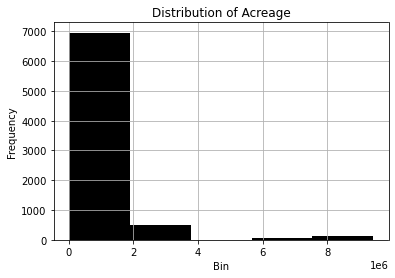

In [110]:
data['acreage'].hist(bins=5, color='black')

# add labels and title
plt.xlabel('Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Acreage')

In [111]:
percentiles = [25, 50, 75, 90, 95]
percentile_values = np.percentile(data['acreage'].dropna(), percentiles)

# Display the calculated percentiles
percentile_dict = {f"{p}th percentile": value for p, value in zip(percentiles, percentile_values)}
percentile_dict

{'25th percentile': 28460.0,
 '50th percentile': 99428.0,
 '75th percentile': 531325.0,
 '90th percentile': 1347644.0,
 '95th percentile': 2358084.0}

### PCA

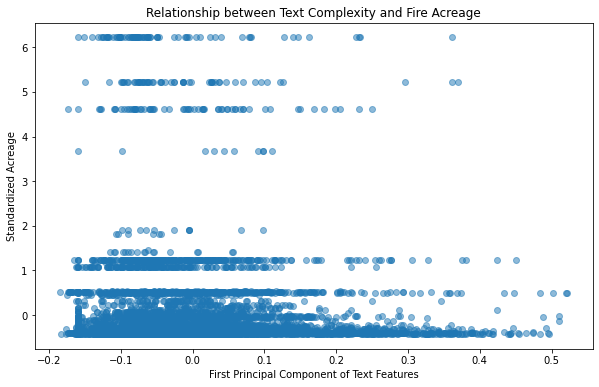

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
tfidf_matrix = vectorizer.fit_transform(data['combined_text'].fillna(''))

pca = PCA(n_components=1)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

# Standardize acreage for better visualization
scaler = StandardScaler()
acreage_scaled = scaler.fit_transform(data[['acreage']])

plt.figure(figsize=(10, 6))
plt.scatter(tfidf_pca, acreage_scaled, alpha=0.5)
plt.xlabel('First Principal Component of Text Features')
plt.ylabel('Standardized Acreage')
plt.title('Relationship between Text Complexity and Fire Acreage')
plt.show()

## Analysis

In [113]:
percentile_thresholds = np.percentile(data['acreage'], [25, 50, 75])
firebins = [0] + list(percentile_thresholds) + [data['acreage'].max()]
size_labels = ['very_small', 'small', 'medium', 'large']

data['size_cat'] = pd.cut(data['acreage'], bins=firebins, labels=size_labels, include_lowest=True)


### Suppression & Containment

In [320]:
data['mentions_suppression'] = data['combined_text'].str.contains('suppression', case=False, na=False).astype(int)
data['mentions_containment'] = data['combined_text'].str.contains('containment', case=False, na=False).astype(int)

In [321]:
token_presence_by_size = data.groupby('size_cat')[['mentions_suppression', 'mentions_containment']].mean()

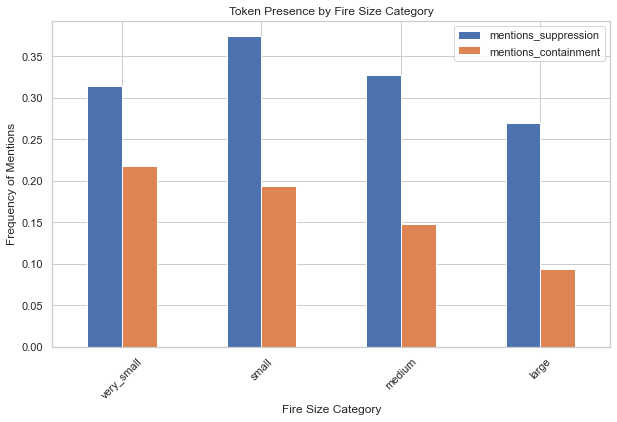

In [322]:
token_presence_by_size.plot(kind='bar', figsize=(10, 6), title="Token Presence by Fire Size Category")
plt.xlabel('Fire Size Category')
plt.ylabel('Frequency of Mentions')
plt.xticks(rotation=45)
plt.show()

### Text Differences By Size

Overall, the text between acreage bins is incredibly similar. The lowest similarity score is between "very_small" and "large", and the highest is between "very_small" and "small". This is intuitive, but not all that much of a difference. Since all cosine similarity scores are close to 1, we can interpret that the language used in reports is quite similar across acreage bins. 

While the difference is slight, it is worth exploring the difference in language between a "very_small" and "large" fire report. It is worth noting that scores are symmetric, and no difference would be found between the score of "very_small" and "small" versus "small" and "very_small". TO avoid clutter, I did not print reduntant scores.

In [323]:
from text_analysis_functions_wagers import average_tfidf_vectors

In [324]:
warnings.filterwarnings('ignore', category=FutureWarning)
tfidf_matrix = vectorizer.fit_transform(data['combined_text'])

average_vectors = {}
for bin_label in size_labels:
    indices = data[data['size_cat'] == bin_label].index
    average_vectors[bin_label] = average_tfidf_vectors(tfidf_matrix, indices)
    cosine_similarities = {}
    
for bin_label_1 in size_labels:
    for bin_label_2 in size_labels:
        if bin_label_1 != bin_label_2:
            # Compute cosine similarity between the average vectors of two different bins
            sim = cosine_similarity(average_vectors[bin_label_1].reshape(1, -1), average_vectors[bin_label_2].reshape(1, -1))[0][0]
            cosine_similarities[(bin_label_1, bin_label_2)] = sim

# Print the cosine similarities without reduntant output
printed_scores = set()

for bins, similarity in cosine_similarities.items():

    bins_tuple = tuple(sorted(bins))
    if bins_tuple not in printed_scores:
        print(f"Cosine similarity between {bins[0]} and {bins[1]}: {similarity}")
        printed_scores.add(bins_tuple)
    
warnings.resetwarnings()

Cosine similarity between very_small and small: 0.973437548010656
Cosine similarity between very_small and medium: 0.9631495620971391
Cosine similarity between very_small and large: 0.8956547732797653
Cosine similarity between small and medium: 0.9707572607183746
Cosine similarity between small and large: 0.902368391976925
Cosine similarity between medium and large: 0.9243229658344538


C:\Users\aidan\AppData\Local\Temp\ipykernel_3924\3555811194.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Cosine Similarity')


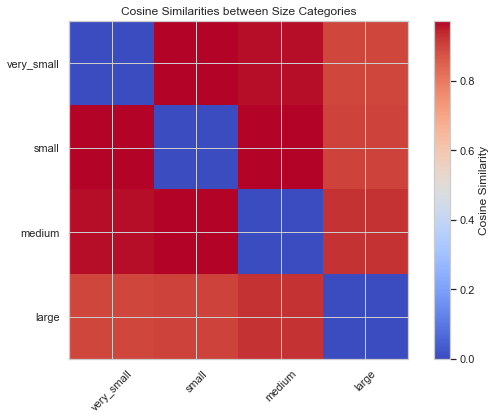

In [377]:
labels = size_labels
num_labels = len(labels)
cosine_matrix = np.zeros((num_labels, num_labels))

for bins, similarity in cosine_similarities.items():
    label_1_idx = labels.index(bins[0])
    label_2_idx = labels.index(bins[1])
    cosine_matrix[label_1_idx, label_2_idx] = similarity

# Plotting heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Cosine Similarities between Size Categories')
plt.colorbar(label='Cosine Similarity')
plt.xticks(np.arange(num_labels), labels, rotation=45)
plt.yticks(np.arange(num_labels), labels)
plt.tight_layout()
plt.show()

C:\Users\aidan\anaconda3\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\Users\aidan\anaconda3\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\Users\aidan\anaconda3\lib\site-packages\seaborn\matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\aidan\anaconda3\lib\site-packages\seaborn\matrix.py:316: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprec

<Figure size 720x576 with 0 Axes>

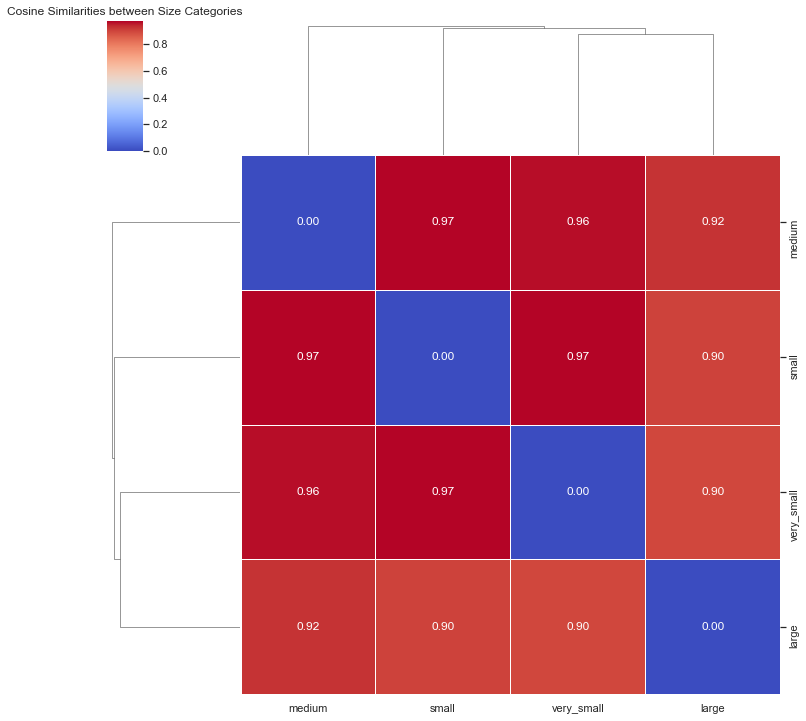

In [378]:
# Constructing data for cluster map
cosine_df = pd.DataFrame(cosine_matrix, index=labels, columns=labels)

# Plotting cluster map
plt.figure(figsize=(10, 8))
sns.clustermap(cosine_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cosine Similarities between Size Categories')
plt.show()

In [380]:
cosine_df.to_csv("cosinesims.csv")

### Predict Large or Very Small

In [325]:
predict_fire_size_and_find_terms(data, ['very_small', 'large'])

Accuracy: 0.8466579292267365
              precision    recall  f1-score   support

  very_small       0.79      0.93      0.85       368
       large       0.92      0.77      0.84       395

    accuracy                           0.85       763
   macro avg       0.85      0.85      0.85       763
weighted avg       0.86      0.85      0.85       763

Most influential terms for 'large' fires:
protection: 3.718108998836952
native: 3.151282345500655
alaska: 2.5211122073163783
outfitter: 2.355129607497298
point: 2.338079766392345
salmon: 2.1463207244715155
scars: 2.0169853158547113
season: 1.99606026215945
spruce: 1.776826816362861
monitoring: 1.6525045519308041
bitterroot: 1.6234002685739402
trail: 1.6047872074392517
trinity: 1.601655020767839
outfitters: 1.582530492697004
cabin: 1.5252289859003731

Most influential terms for 'very_small' fires:
roads: -3.297736780144408
private: -2.6986444813720416
monsoonal: -2.1664427122274987
monsoon: -1.9253556230045052
sage: -1.613087884017363
te

### Predict Large or Small

In [326]:
predict_fire_size_and_find_terms(data, ['small', 'large'])

Accuracy: 0.8430851063829787
              precision    recall  f1-score   support

       small       0.81      0.87      0.84       359
       large       0.88      0.81      0.84       393

    accuracy                           0.84       752
   macro avg       0.84      0.84      0.84       752
weighted avg       0.85      0.84      0.84       752

Most influential terms for 'large' fires:
protection: 3.3486593113577188
native: 3.255393931076179
alaska: 2.542214235393439
outfitter: 2.2671076769367904
scars: 2.2241207585323233
bitterroot: 2.220027737634488
point: 2.041228645228332
yosemite: 1.933195969016072
salmon: 1.7521701558317717
fork: 1.5871055103941114
moderated: 1.5773152781133002
outfitters: 1.5754039637398563
trinity: 1.5368515559852474
season: 1.5312395028008863
allotments: 1.4891486376415697

Most influential terms for 'small' fires:
monsoon: -2.9628664626175025
monsoonal: -2.728054225498229
roads: -2.240626140155748
habitat: -2.229571149191678
canyon: -1.88539438370862

### Predict Large or Medium

In [327]:
predict_fire_size_and_find_terms(data, ['medium', 'large'])

Accuracy: 0.8005215123859192
              precision    recall  f1-score   support

      medium       0.76      0.89      0.82       389
       large       0.86      0.71      0.78       378

    accuracy                           0.80       767
   macro avg       0.81      0.80      0.80       767
weighted avg       0.81      0.80      0.80       767

Most influential terms for 'large' fires:
protection: 3.0784352298288997
native: 2.9333441173100554
alaska: 2.5923209252123782
bitterroot: 2.406094086311893
middle: 1.8154937748415834
outfitter: 1.727971967238628
lolo: 1.5686339019431514
moose: 1.5406290605055906
remote: 1.5271559957743355
trinity: 1.5082599564029624
continues: 1.4285433676900225
monitor: 1.4044070170451128
scars: 1.3975491799478612
allotments: 1.3553258562644408
gila: 1.3492525612254784

Most influential terms for 'medium' fires:
sage: -2.514131280014576
private: -1.951745952465015
grouse: -1.9416989478755664
habitat: -1.881710890300471
gas: -1.3599736300321958
steep: 

### Predict Medium or Small

In [328]:
predict_fire_size_and_find_terms(data, ['small', 'medium'])

Accuracy: 0.7207792207792207
              precision    recall  f1-score   support

       small       0.75      0.67      0.71       392
      medium       0.69      0.77      0.73       378

    accuracy                           0.72       770
   macro avg       0.72      0.72      0.72       770
weighted avg       0.72      0.72      0.72       770

Most influential terms for 'medium' fires:
structures: 1.8029774964464742
outfitter: 1.4013324579405735
wilderness: 1.3848256719031231
popular: 1.3834950937483137
hwy: 1.2800921336202364
large: 1.2727776517175557
portion: 1.2057656666701466
salmon: 1.1936643535227822
golden: 1.1930413871616343
elevation: 1.176777747368168
fork: 1.152127457586857
dead: 1.0954944759921492
developed: 1.0937704896880258
manage: 1.0692428663701257
moderated: 1.0433382590384002

Most influential terms for 'small' fires:
lava: -2.3026879534198335
monsoonal: -2.152334351153151
monsoon: -1.9081855005150603
canyon: -1.4594432892082445
roads: -1.4053123239376595
d

### Predict Medium or Very Small

In [329]:
predict_fire_size_and_find_terms(data, ['very_small', 'medium'])

Accuracy: 0.7084398976982097
              precision    recall  f1-score   support

  very_small       0.67      0.76      0.71       375
      medium       0.75      0.66      0.70       407

    accuracy                           0.71       782
   macro avg       0.71      0.71      0.71       782
weighted avg       0.71      0.71      0.71       782

Most influential terms for 'medium' fires:
barriers: 1.703868883556061
habitat: 1.5967717136602435
tree: 1.5905955104866394
closures: 1.4359067198690239
trout: 1.4349987489932936
salmon: 1.4305200087249743
sage: 1.4222343133445257
elevation: 1.4107331370109928
oil: 1.3252751696556393
outfitter: 1.2662074985574165
meadows: 1.2327019496143599
golden: 1.1895311063038043
dead: 1.170143197947915
entirely: 1.1599326967099106
wx: 1.1553343465305466

Most influential terms for 'very_small' fires:
roads: -2.4746199581794
monsoonal: -2.0417899867843734
lines: -1.794128562535764
easily: -1.4681849487844874
power: -1.4225037897672115
media: -1.3181

### Predict Small or Very Small 

In [330]:
predict_fire_size_and_find_terms(data, ['small', 'very_small'])

Accuracy: 0.7079530638852672
              precision    recall  f1-score   support

       small       0.73      0.66      0.69       384
  very_small       0.69      0.76      0.72       383

    accuracy                           0.71       767
   macro avg       0.71      0.71      0.71       767
weighted avg       0.71      0.71      0.71       767

Most influential terms for 'very_small' fires:
lines: 1.8525967327538642
rugged: 1.6867858135075189
structures: 1.4189128402193685
contained: 1.3808489220100888
identified: 1.2616564513365052
unit: 1.1818825918062583
good: 1.157811706533216
black: 1.1518606507340585
burned: 1.1517572382194436
beetle: 1.124471263712029
refuge: 1.113688387042402
influence: 1.0959630065909307
regional: 1.0649937412210126
kbdi: 1.0469378567433085
media: 1.0345306330299606

Most influential terms for 'small' fires:
park: -1.8615066452672735
canyon: -1.8342846616770314
habitat: -1.8227231736380518
oil: -1.788530994768353
rated: -1.5601010840336866
lava: -1.55

### Predict From All

In [331]:
acre_texts = data['combined_text']
acre_labels = data['size_cat']
acre_x = vectorizer.fit_transform(acre_texts)

acre_model, acrex_train, acrex_test,\
acrey_train, acrey_test = train_logistic_reg(acre_texts,acre_labels,'l2',1.1,1000)

acre_pred = acre_model.predict(acrex_test)
acre_score = accuracy_score(acrey_test, acre_pred)

print(f"A penalized logistic regression model classifying risk has an accuracy of {acre_score}\n")
print("Classification Report:")
print(classification_report(acrey_test, acre_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.5707762557077626

Classification Report:
              precision    recall  f1-score   support

       large       0.71      0.66      0.69       394
      medium       0.50      0.47      0.49       392
       small       0.59      0.54      0.56       365
  very_small       0.50      0.61      0.55       382

    accuracy                           0.57      1533
   macro avg       0.58      0.57      0.57      1533
weighted avg       0.58      0.57      0.57      1533



# Specific Questions

In [165]:
lem_data = data.copy()

In [166]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK's POS tags to WordNet's POS tags
def nltk_to_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function to lemmatize a single token
def lemmatize_token(token, pos_tag):
    wordnet_pos = nltk_to_wordnet_pos(pos_tag)
    if wordnet_pos is not None:
        return lemmatizer.lemmatize(token, pos=wordnet_pos)
    else:
        return lemmatizer.lemmatize(token)

# Function to lemmatize text in a column
def lemmatize_text_column(text_column):
    lemmatized_text = []
    for text in text_column:
        tokens = nltk.word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)
        lemmatized_tokens = [lemmatize_token(token, pos_tag) for token, pos_tag in pos_tags]
        lemmatized_text.append(' '.join(lemmatized_tokens))
    return lemmatized_text

def average_tfidf_vectors(matrix, indices):
    # Extract the rows corresponding to the indices for the bin
    bin_matrix = matrix[indices]
    # Calculate the mean vector (axis=0 computes the mean of each column, resulting in a mean vector)
    average_vector = np.mean(bin_matrix, axis=0)
    return average_vector



# Lemmatize the text column
lem_data['lemmatized_text'] = lemmatize_text_column(lem_data['combined_text'])


In [167]:
lem_text = lem_data['lemmatized_text']
lem_labels = lem_data['rrf_rr_desc']

lem_plr_model, lem_lrx_train, lem_lrx_test,\
lem_lry_train, lem_lry_test = train_logistic_reg(lem_text,lem_labels,'l2',1,1000)

In [174]:
lem_lry_pred = lem_plr_model.predict(lem_lrx_test)
lem_plr_score = accuracy_score(lem_lry_test, lem_lry_pred)

In [175]:
lem_plr_score

0.6060013046314416

In [173]:
plr_score

0.6033920417482062